### Initialisations

In [1]:
import os, sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Running in Google CoLab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    global_prefix = '/content/gdrive/MyDrive/Colab Notebooks/Jupyter-Puzzles/python/sudoku/'
    os.chdir(global_prefix)
else:
    # Not running in Google CoLab
    global_prefix = os.getcwd().replace('\\','/') + '/'

#! pip install py-sudoku
import re
import numpy as np
from copy import deepcopy
import pathlib
import pickle
from sudoku import Sudoku
import itertools

sys.path.append(f'{global_prefix}../outils')
import displayImages
import find_all_cycles

# [Sudoku](https://fr.wikipedia.org/wiki/Sudoku)


Une grille de sudoku, admettant une unique solution, étant donnée, il s'agit de produire une suite d'images ; chaque image expliquant une étape de la résolution.

Par exemple, pour un sudoku $4\times 4$  
![4x4.png](images/documentation/4x4.png)

Les grilles traitées sont de dimension $n\times n$ où $n=m^2$ avec $m = 2,3,4$ ou $5$  
Par la suite tous les exemples seront donnés dans le cas classique $n=9$.


# Documentation

## Vocabulaire


Les *lignes* sont numérotées du haut vers le bas $L_1,\ldots,L_n$.  
Les *colonnes* sont numérotées de gauche à droite $C_1,\ldots,C_n$.  
Les  *blocs* $m\times m$ sont numérotés de $1$ à $n$ comme dans la figure ci-dessous  
![blocs.png](images/documentation/blocs.png)

Une ligne, une colonne ou un bloc est appelé une *région*.  
Les régions d'un type donné sont donc numérotées 
de $1$ à $n$ (mais elles le seront de $0$ à $n-1$ pour l'implémentation).

La *cellule* intersection de la ligne $i$ et de la colonne $j$ est notée $L_iC_j$ ou simplement $ij$.  
Plus généralement, si $i_1,\ldots,i_p, j_1,\ldots,j_q\in\{1,\ldots,n\}$, l'ensemble de toutes les cellules
$i_kj_\ell$ est noté $L_{i_1\ldots i_p}C_{j_1\ldots j_q}$.  
Par exemple, pour $n=9$, le bloc 4 est constitué des cellules de $L_{456}C_{123}$.

La *valeur* $\text{val}(c)$ d'une cellule $c=ij$ est la valeur de cette cellule une fois le sudoku résolu.  
On dit qu'une cellule en *voit* une autre s'il existe une région qui contient les deux cellules.
Deux cellules qui se voient ont donc des valeurs différentes.

A une étape donnée de la résolution, la
valeur d'une cellule $c$ peut être *connue* ou *inconnue*. Si elle est inconnue, on appelle *candidat* de $c$ une valeur $v\in\{1,\ldots n\}$
dont on ne sait pas, à cette étape de la résolution, si elle est égale à $\text{val}(c)$.  
Chaque étape de la résolution correspond à un  $état$ du sudoku que l'on représente, comme dans la figure suivante, où chaque cellule contient sa valeur si elle est connue ou l'ensemble de ses candidats sinon.  
![etat.png](images/documentation/etat.png)

Le passage de l'étape $p$ à l'étape $p+1$ consiste  
- soit à trouver la valeur d'une cellule $c$ inconnue à l'étape $p$ (ce qui élimine cette valeur comme candidate des autres cellules de chacune des 3 régions qui contiennent $c$) ;  
- soit à éliminer un ou plusieurs candidats d'une ou de plusieurs cellules.

Pour ce faire, on utilise une des techniques décrites ci-dessous. La preuve du fait que cette technique 
permet bien le passage de l'étape $p$ à l'étape $p+1$ sera appelée l'*explication* du passage.


## Techniques fournissant la valeur d'une cellule

Ces techniques, au nombre de deux, sont évidentes et on n'en connait pas vraiment de plus subtiles.  
Il s'agit de *SINGLE CANDIDATE* et *SINGLE POSITION*.

### SINGLE CANDIDATE


Si une cellule ne possède qu'un seul candidat, il s'agit de sa valeur.

Dans l'exemple suivant, $\text{val}(13)=7$

![single-candidate-1](images/documentation/single-candidate-1.png)

Dans certains cas la technique s'applique sans qu'il soit nécessaire de consulter les candidats

![single-candidate-2](images/documentation/single-candidate-2.png)



### SINGLE POSITION


S'il n'y a qu'une seule cellule  d'une région donnée qui possède le candidat $v$,
cette cellule a pour valeur $v$.

Dans l'exemple suivant, $\text{val}(26)=5$

![single-position-1](images/documentation/single-position-1.png)

Dans certains cas la technique s'applique sans qu'il soit nécessaire de consulter les candidats

![single-position-2](images/documentation/single-position-2.png)

## Techniques d'élimination de candidats

### Principes généraux

#### Liens et chaines

Un candidat étant donné par une valeur possible $v$ d'une cellule non évaluée $c=ij$, 
on le représente par le couple $C=(c,v)$.

On dit que deux candidats distincts $C=(c,v)$ et $C'=(c',v')$ sont *faiblement liés* et on écrit $C\;..\;C'$ si  
- ou bien $c'=c$ ;
- ou bien $v'=v$ et $c$ et $c'$ se voient.

**Propriété** si  $C\;..\;C'$ alors $v=\text{val}(c)\Longrightarrow v'\neq\text{val}(c')$.

On dit que $C$ et $C'$ sont *fortement liés* et on écrit $C\;\_\;C'$ si 
- ou bien $c'=c$ et $v$ et $v'$ sont les seuls candidats de la cellule $c$ ;
- ou bien $v'=v$ et il existe une région
dont les cellules qui ont $v$ pour candidat sont exactement $c$ et $c'$.

Noter que $C\;\_\;C'\Longrightarrow C\;..\;C'$

**Propriété** si  $C\;\_\;C'$ alors  $v\neq\text{val}(c)\Longrightarrow v'=\text{val}(c')$.

On dira qu'une suite $C_1=(c_1,v_1),\ldots,C_n=(c_n,v_n)$ est une *chaîne* si 
elle forme un chemin dans le graphe non orienté dont les sommets sont les candidats et les arêtes sont les liens ; et si, de plus,
les arêtes de ce chemin sont alternativement faibles et fortes. Autrement dit,

soit $C_1\;\_\;C_2\;..\;C_3\;\_\;C_4\;..\;C_5\;\_\;\ldots$

soit $C_1\;..\;C_2\;\_\;C_3\;..\;C_4\;\_\;C_5\;..\;\ldots$

Disons qu'un candidat $C=(c,v)$ est *positif* (resp. *négatif*) si $v=\text{val}(c)$ (resp. $v\neq\text{val}(c)$).  
On dira qu'un chaîne est *faible* (resp. *forte*) si son premier et son dernier lien sont faibles (resp. forts) ;
elle contient alors un nombre pair de candidats.

Les propriétés précédentes se généralisent, par récurrence, aux chaînes :

**propriété** s'il existe une chaîne faible reliant deux candidats, l'un des deux est négatif.

**propriété** s'il existe une chaîne forte reliant deux candidats, l'un des deux est positif.



Graphiquement, on représente un lien faible (resp. fort) entre deux candidats 
de cellules différentes par un trait en pointillé (resp. par un trait plein).  
On ne représente pas les liens entre candidats d'une même cellule.

La figure suivante représente la chaîne

$(12,1)\;\_\;(42,1)\;..\;(59,1)\;\_\;(59,6)\;..\;(39,6)\;\_\;(39,3)\;..\;(34,3)\;\_\;(16,3)$

![chain-ex1.png](images/documentation/chain-ex1.png)

Dans certains cas, comme dans la figure ci-dessous, la chaîne n'apparait
pas de manière évidente. Mais, comme on sait qu'il s'agit d'une chaîne,
il est facile de la lire. Ainsi, ici :  

$(91,1)\;\_\;(73,1)\;..\;(74,1)\;\_\;(74,2)\;..\;(78,2)\;\_\;(78,9)\;..\;(72,9)\;\_\;(72,3)$

![chain-ex2.png](images/documentation/chain-ex2.png)




#### LSs, ALSs, etc.

Supposons que chacune de 2 cellules d'une même région ait exactement pour candidats $1$ et $2$. Alors l'une de ces 2 cellules a pour valeur $1$ et l'autre $2$ (et aucune des autres cellules de la région n'a pour valeur $1$ ou $2$).

Plus généralement, considérons un ensemble $E$ de $p$ cellules non évaluées d'une même région $R$ et désignons par $V_E$ la réunion des valeurs des candidats des cellules de $E$.

Si $\text{Card}(V_E)=p$ alors, comme les cellules de $E$ ont des valeurs différentes,
l'ensemble des valeurs des cellules de $E$ est exactement $V_E$
(et les valeurs des cellules de $R\setminus E$ seront différentes des valeurs de $V_E$).  
On dit que $E$ est un *LS* (*locked set*).

Exemple d'un LS avec $E=\{71,74,75,76\}$, $p=4$, $R=L_7$ et $V=\{3,4,5,6\}$
(remarquer que l'on peut éliminer les candidats $(73,4)$, $(77,3)$ et $(77,6)$)

![LS.png](images/documentation/LS.png)

Si $\text{Card}(V_E)=p+1$, $E$ est appelé un *ALS* (*almost locked set*). Si, sous certaines hypothèses, on arrive à
montrer qu'une valeur particulière de $V_E$ ne peut pas être la valeur d'une cellule de $E$, alors $E$ "devient" en quelque sorte un LS
et on peut lui appliquer les propriétés des LS.

Exemple d'ALS :

![als.png](images/documentation/als.png)

Si $\text{Card}(V_E)=p+q$, on parle d'*A* $\!{}^q\!$ *LS* (*almost almost $\ldots$ locked set*).  
Un LS est un A $\!{}^0\!$ LS, un ALS est un A $\!{}^1\!$ LS.  
Un A $\!{}^{-1}\!$ LS ne peut exister ($p-1$ valeurs ne peuvent remplir $p$ cellules) mais cette notion 
peut servir dans des raisonnements par l'absurde.


### LOCKED CANDIDATE

Appelons *sous region* l'intersection d'une ligne ou d'une colonne avec un bloc si cette intersection est non vide ; 
elle  contient alors $m$ cellules.

**Données**
- une sous-region $S=R_1\cap R_2$ (l'une des deux régions $R_1$ ou $R_2$ est une ligne ou une colonne et l'autre est un bloc) ;
- une valeur $v$ qui apparait dans les candidats de $S$ mais pas dans ceux de $R_1\setminus S$.

**Conclusion**
les candidats de $R_2\setminus S$ dont la valeur est $v$ peuvent être éliminés.

En effet, si un tel candidat était positif, alors $S$, et donc aussi $R_1$, ne contiendrait pas la valeur $v$.

Exemples (en rouge les candidats à éliminer)

![locked-candidate-1.png](images/documentation/locked-candidate-1.png)
![locked-candidate-2.png](images/documentation/locked-candidate-2.png)

### NAKED TUPLE

**Données** une région $R$ et un [LS](#LSs,-ALSs,-etc.) $E\subset R$.

**Conclusion** les candidats de $R\subset E$ dont la valeur est dans $V_E$ peuvent être éliminés (voir [LS](#LSs,-ALSs,-etc.)).

Exemples

![naked-tuple-1.png](images/documentation/naked-tuple-1.png)
![naked-tuple-2.png](images/documentation/naked-tuple-2.png)



### HIDDEN TUPLE

**Données** une région $R$ et un ensemble $V$ de $p$ valeurs.  
On suppose que l'ensemble $E_V$ des cellules de $R$ qui contiennent au moins un élément de $V$ est de cardinal $p$. 

**Conclusion** les candidats de $E_V$ dont la valeur n'est pas dans $V$ peuvent être éliminés.

En effet, les $p$ valeurs de $V$ doivent se partager les $p$ cellules de $E_V$ et il ne reste plus de place 
pour d'autres valeurs.

Exemple avec $R=L_6$, $V=\{5,7,9\}$ et $E_V=L_6C_{239}$

![hidden-tuple.png](images/documentation/hidden-tuple.png)


### W WING

**Données**  
Une région $R$, deux valeurs $v$ et $w$, deux cellules $A$ et $A'$ dont les candidats sont $v$ et $w$, ne se voyant pas
et non contenues dans $R$.  
On suppose que chaque cellule de $R$, qui admet $w$ comme candidat, voit $A$ ou $A'$. 

**Conclusion**  
Tout candidat de valeur $v$ et dont la cellule voit $A$ et $A'$ peut être éliminé.  

En effet, si un tel candidat était positif, les deux cellules $A$ et $A'$ auraient la valeur $w$
et aucune cellule de $R$ n'aurait la valeur $w$.

Exemples

![w-wing-1.png](images/documentation/w-wing-1.png)
![w-wing-2.png](images/documentation/w-wing-2.png)

### Y WING et NY WING

Dans ce qui suit, on peut remplacer ligne par colonne.

**Données**  
Deux lignes $L^1$ et $L^2$ qui rencontrent deux blocs $B^1$ et $B^2$.  
Un ensemble $F$ de valeurs et une valeur supplémentaire $v\not\in F$.  
trois ensembles de cellules non évaluées  $E_{11}\subset L^1\cap B^1$, $E_{22}\subset L^2\cap B^2$ et $E_{12}\subset L^1\cap B^2$.  
Soit $V_E$ la réunion  des candidats des cellules de $E=E_{11}\cup E_{22}\cup E_{12}$. On suppose que    
$V_E\subset F\cup\{v\}$, $v\not\in V_{E_{12}}$, $(V_{E_{11}}\setminus\{v\})\cap(V_{E_{22}}\setminus\{v\})=\emptyset$
et $\text{Card}(E)=\text{Card}(F)+1$.  

**Conclusion**
Les candidats de valeur $v$ des cellules de $(L^2\cap B^1)\cup(L^1\cap B^2)$ peuvent être éliminés.

En effet, si un tel candidat était positif, les cellules de $E$ contiendraient des éléments distincts de $F$,
ce qui n'est pas possible car il y a strictement plus de cellules dans $E$ que de valeurs dans $F$.

Exemples  
Dans le premier exemple, $L^1=L_2$ $L^2=L_1$, $B^1=B_1$, $B^2=B_3$, $v=9$.      
Dans le cas le plus simple où $\text{Card}(F)=2$, on parle de la technique Y WING.  
![ny-wing.png](images/documentation/ny-wing.png)
![y-wing.png](images/documentation/y-wing.png)



### SUEDECOQ

**Données**    
Deux régions $R_1$ et $R_2$ dont l'intersection est formée de $m$ cellules.  
Un ensemble $F$ de valeurs.  
Trois ensembles de cellules $E_{12}\subset R_1\cap R_2$, $E_1\subset R_1\setminus R_2$ et $E_2\subset R_2\setminus R_1$.  
On suppose que l'ensemble $V_{E_{12}}$ des candidats des cellules de $E_{12}$ est $F$,  
que $V_{E_1}\subset F$,  $V_{E_2}\subset F$, $V_{E_1}\cap V_{E_2}=\emptyset$ et enfin  $p=\text{Card}(E)=\text{Card}(F)$ où
$E=E_{12}\cup E_{1}\cup E_{2}$.

**Conclusion**  
Les candidats dont la valeur est dans $F\setminus V_{E_2}$ et la cellule dans $R_1\setminus E$
peuvent être éliminés ; et idem en échangeant les indices 1 et 2.

En effet, si un tel candidat $(c,v)$ était positif, les $p$ cellules de $E$ devraient avoir 
des valeurs distinctes choisies dans les $p-1$ valeurs de $F\setminus\{v\}$.

Exemple   
![suedecoq.png](images/documentation/suedecoq.png)


### SUEDECOQ BIS

Cette technique utilise la notion d'[ALS](#LSs,-ALSs,-etc.)

**Données**    
Deux régions $R_1$ et $R_2$ dont l'intersection est formée de $m$ cellules.  
Un A $\!{}^{2}\!$ LS $E\subset R_1\cap R_2$.  
Un ALS $E_1\subset R_1\setminus R_2$ ayant au moins 2 candidats en commun avec $E$.  
Un ALS $E_2\subset R_2\setminus R_1$ dont les candidats sont disjoints de ceux de $E_1$ et ayant au moins 2 candidats en commun avec $E$.  

**Conclusion**  
Les candidats dont la valeur est dans $V_{E_1}$ et la cellule dans $R_1\setminus E_1\setminus E$
peuvent être éliminés ; et idem en remplaçant 1 par 2.

En effet, si un tel candidat $(c,v)$ était positif, $v$ serait
négatif dans $E_1$ qui deviendrait un LS. Toutes les valeurs des candidats de $E_1$ (et en particulier les 2 valeurs communes
à $E_1$ et $E$) seraient atteintes dans $R_1\setminus E$ et $E$ deviendrait un LS.  
Mais au moins 1 candidat commun à $E_2$ et $E$ est positif dans $E_2$ et donc négatif dans $E$ qui deviendrait ainsi un
A $\!{}^{-1}\!$ LS, ce qui est impossible.

Exemple   
![suedecoq-bis.png](images/documentation/suedecoq-bis.png)


### X WING, SWORDFISH et JELLYFISH

Dans ce qui suit, on peut échanger ligne et colonne.

**Données**
Une valeur $v$.  
Un ensemble de $p\geqslant2$ lignes $\{L^1,\ldots,L^p\}$ dans lesquelles $v$ n'est pas évalué.  
Si $E_i$ est l'ensemble des cellules de $L^i$ qui admettent $v$ pour candidat et $E=\cup_i E_i$,
on suppose que les colonnes des cellules de $E$ sont exactement au nombre de $p$ : $\{C^1,\ldots,C^p\}$.

**Conclusion**   
Tout candidat de valeur $v$ situé sur une colonne contenant au moins une cellule de $E$ (mais non situé dans une cellule de $E$)
peut être éliminé.

En effet, supposons qu'un tel candidat soit positif et soit $C^1$ sa colonne. Alors les  candidats $v$ 
des cellules de $E$ situés dans $C^1$ sont négatifs. Donc, pour chacune des $p$ lignes $L^i$, l'élément de
la ligne $L^i$ de valeur $v$ se trouve
parmi les $p-1$ colonnes $C^2,\ldots,C^p$. Une de ces $p-1$ colonnes contient donc deux fois la valeur $v$ : impossible.

Si $p=$ 2, 3 ou 4 on parle de X WING, SWORDFISH ou JELLYFISH respectivement.

Exemples  
![x-wing.png](images/documentation/x-wing.png)
![swordfish.png](images/documentation/swordfish.png)
![jellyfish.png](images/documentation/jellyfish.png)

### FINNED X WING, SWORDFISH et JELLYFISH

Dans ce qui suit, on peut échanger ligne et colonne.

**Données**  
Une valeur $v$.    
Un bloc $R$.  
Un ensemble de $p\geqslant2$ lignes $\{L^1,\ldots,L^p\}$ dans lesquelles $v$ n'est pas évalué.  
On suppose que, parmi ces lignes, il y en a $r\in\{1,\ldots,m-1\}$ : $\{L^1,\ldots,L^r\}$, qui rencontrent 
le bloc $R$.    
Soit $E_i$ l'ensemble des cellules de $L^i\setminus R$ qui admettent $v$ pour candidat.    
Considérons les colonnes  $\{C^1,\ldots,C^q\}$ des cellules de $E=\cup_i E_i$.  

**Conclusion**  
- Cas 1 : si  au moins une des colonnes $C^j$ rencontre $R$ et si $q = p$,  
on peut éliminer tout candidat de valeur $v$ situé dans $C^j\cap R\setminus(L^1\cup\dots\cup L^r)$.
- Cas 2 : si aucune des colonnes $C^j$ ne rencontre $R$ et si $q=p-1$,  
on peut éliminer tout candidat de valeur $v$ situé dans $R\setminus(L^1\cup\dots\cup L^r)$.

Démonstration
- Cas 1 : 
supposons qu'un tel candidat soit positif. Alors les  candidats $v$ 
des cellules de $(\cup_iL^i)\cap C^j$ sont négatifs. Donc, pour chacune des $p$ lignes $L^i$, l'élément de
la ligne $L^i$ de valeur $v$ se trouve
parmi les $p-1$ colonnes $\{C^1,\ldots,C^p\}\setminus \{C^j\}$. Une de ces $p-1$ colonnes contient donc deux fois la valeur $v$ : impossible.
- Cas 2 : si un candidat de valeur $v$ situé dans $R\setminus(L^1\cup\dots\cup L^r)$ est positif,  
alors, là encore,  pour chacune des $p$ lignes $L^i$, l'élément de
la ligne $L^i$ de valeur $v$ n'est pas dans $R$ et se trouve donc
parmi les $p-1$ colonnes $\{C^1,\ldots,C^q\}$. 

Noter que le cas 2 est très rare.

Si $p=$ 2, 3 ou 4 on parle de FINNED X WING, FINNED SWORDFISH ou FINNED JELLYFISH respectivement.

Exemples  
![finned-x-wing.png](images/documentation/finned-x-wing.png)
![finned-x-wing2.png](images/documentation/finned-x-wing2.png)
![finned-swordfish.png](images/documentation/finned-swordfish.png)
![finned-swordfish2.png](images/documentation/finned-swordfish2.png)
![finned-jellyfish.png](images/documentation/finned-jellyfish.png)
![finned-jellyfish2.png](images/documentation/finned-jellyfish2.png)


### MEDUSA

**Données**  
Une [chaine](#liens-et-chaines) dont tous les liens sont forts.  

Notons $C_1\;\_\;C_2\;\_\;\ldots\;\_\;C_n$ cette chaine.  
On peut distinguer les candidats d'ordre impair $C_{2i+1}$ de cette chaine et les candidats d'ordre pair $C_{2i}$.

**Conclusion**   
Tout candidat $C$ faiblement lié à un candidat pair $C_{2i}$ de la chaine, et aussi à un candidat impair $C_{2j+1}$,
peut être éliminé.

En effet, la sous chaine de la chaine initiale reliant $C_{2i}$ à $C_{2j+1}$ est une chaine forte. 
Donc l'un des deux candidats  $C_{2i}$ ou $C_{2j+1}$ est positif, ce qui impose que $C$ soit négatif.

Exemple  
![medusa.png](images/documentation/medusa.png)   

On notera que, dans cet exemple, $n$ est pair et que les seuls candidats éliminés
ont un lien avec $C_1$ et avec $C_n$. Cela est dû au fait que l'on arrête la construction de la chaine dés que l'on trouve 
au moins un candidat à éliminer.

### CHAIN

**Données**  
Une [chaine forte](#liens-et-chaines).  

**Conclusion**   
Tout candidat $C$ faiblement lié à chaque extrémité de la chaine, peut être éliminé.

En effet, l'une des 2 extrémités de la chaine est positive, ce qui impose que $C$ soit négatif.

Exemples   
![chain-1.png](images/documentation/chain-1.png)
![chain-2.png](images/documentation/chain-2.png)   


### LOOP

Un *cycle* est une [chaine](#liens-et-chaines) de longueur (nombre de liens) paire $n=2p\geqslant4$
dont les deux extrémités coïncident :   
$C_0\;..\;C_1\;\_\;\ldots\;\_\;C_{n}=C_0$  
Un tel cycle est considéré comme égal à chacun des $n-1$ autres cycles
obtenus par permutation circulaire :  
$C_1\;\_\;\ldots\;\_\;C_{n}\;..\;C_1$,  
$\dots$  
$C_{n-1}\;\_\;C_0\;..\;\ldots\;..\;C_{n-1}$.

**Données**  
Un cycle.

**Conclusion**  
pour chaque lien faible $A=C_{2i}\;..\;C_{2i+1}=B$ du cycle, on peut éliminer 
les candidats $C$ qui ont un lien faible avec $A$ et avec $B$.

En effet, si l'on supprime du cycle le lien faible  $A\;..\;B$ (sans supprimer $A$ ni $B$), on obtient une
chaine forte, de sorte que, comme dans la technique [CHAIN](#CHAIN), $A$ ou $B$ est positif et que $C$ est négatif.

Exemples  
![loop0.png](images/documentation/loop0.png)
![loop1.png](images/documentation/loop1.png)



### BAD LOOP


Un *faux cycle* est une [chaine](#liens-et-chaines) de longueur (nombre de liens) impaire $n=2p+1\geqslant3$
dont les deux extrémités coïncident.  
Soit la chaine est faible : $C_0\;..\;C_1\;\_\;\ldots\;..\;C_{n}=C_0$ ;  
soit elle est forte $C_0\;\_\;C_1\;..\;\ldots\;\_\;C_{n}=C_0$

**Données**  
Un faux cycle.

**Conclusion**  
Si la chaine est faible on éliminer l'extrémité $C_0$ ;  
et, si elle est forte, $C_0$ est positif et on peut éliminer tous les candidats faiblement liés à  $C_0$.

En effet, on sait que, pour une chaine faible (resp. forte), l'une des extrémités, ici $C_0$ qui est l'unique extrémité, est négative
(resp. positive).

Exemples  
![bad-loop-1.png](images/documentation/bad-loop-1.png)
![bad-loop-2.png](images/documentation/bad-loop-2.png)

### EMPTY RECTANGLE

Dans ce qui suit, on peut échanger ligne et colonne.

**Données**  
Une [chaine](#liens-et-chaines) $C_1\;..\;C_2\;\_\;\ldots\;\_\;C_n$ dont le premier lien est faible et le dernier fort.  
Soit $B$ le bloc qui contient $L^1\cap C^n$ où $L^1$ est la ligne qui contient $C_1$
et $C^n$ est la colonne qui contient $C_n$.  
On suppose que les candidats $C_1$ et $C_n$ ont la même valeur $v$, que leurs cellules
ne sont pas dans $B$
et que les cellules de $B$ dont la valeur est $v$ sont dans $L^1\cup C^n$.   

**Conclusion**   
$C_1$ peut être éliminé.

En effet, si $C_1$ était positif, $C_n$ le serait aussi et aucune cellule de $B$ n'aurait la valeur $v$.

Exemples   
![empty-rectangle-1.png](images/documentation/empty-rectangle-1.png)
![empty-rectangle-2.png](images/documentation/empty-rectangle-2.png)   



### ALS

Une *valeur commune exclusive* (*RCC*) à 2 [ALS](#LSs,-ALSs,-etc.)s est une valeur $v$
qui est candidate de chacun des 2 ALSs et qui vérifie
que chaque cellule d'un des ALSs qui admet $v$ pour candidat voit
chaque cellule de l'autre ALS qui admet $v$ pour candidat.
De plus aucune cellule commune aux 2 ALSs n'admet $v$ pour candidat.

**Données**  
Deux ALSs admettant une RCC $v$.

**Conclusion**   
On peut éliminer les candidats $C=(c,w)$ si $c$ n'appartient à aucun des 2 ALSs,
$w\neq v$ est une valeur commune aux 2 ALSs (exclusive ou non) et si $c$ voit toute cellule
de chacun des 2 ALSs qui admet $w$ pour candidat.

En effet, supposons $C$ positif. Alors aucune cellule de chacun des 2 ALSs n'admet $w$ comme valeur.
Chacun des 2 ALSs devient donc un LS. Ainsi $v$ est une valeur de chaque ALS ce qui est impossible vu
les hypothèses.

Exemples ; un des ALSs est indiqué par les cellules pleines, l'autre par les cellules encadrées.
La RCC est mise en évidence dans chacun.

![als-1.png](images/documentation/als-1.png)
![als-2.png](images/documentation/als-2.png)

### CELL FC (cell forced chain)

**Données**  
Une cellule $c$ non évaluée et un candidat $D$.  
On suppose l'une ou l'autre des conditions suivantes
- Cas $+$ chaque candidat de $c$ est relié à $D$ par une [chaine](#liens-et-chaines) dont la première arête est faible et la dernière forte, 
- Cas $-$ chaque candidat de $c$ est relié à $D$ par une chaine faible.

**Conclusion**
- Cas $+$ $D$ est positif,
- Cas $-$ $D$ est négatif.

En effet, dans chaque cas, si la conclusion était erronée, tous les candidats de $c$ seraient négatifs.

Exemples  
![cellFC-1.png](images/documentation/cellFC-1.png)
![cellFC-2.png](images/documentation/cellFC-2.png)  

### REGION FC (region forced chain)

**Données**  
Une région $R$, une valeur $v$ non positionnée dans $R$ et un candidat $D$.  
On suppose l'une ou l'autre des conditions suivantes
- Cas $+$ chaque candidat de $R$ ayant la valeur $v$ est relié à $D$ par une [chaine](#liens-et-chaines) dont la première arête est faible et la dernière forte, 
- Cas $-$ chaque candidat de $R$ ayant la valeur $v$ est relié à $D$ par un chaine faible.

**Conclusion**  
- Cas $+$ $D$ est positif,
- Cas $-$ $D$ est négatif.

En effet, dans chaque cas, si la conclusion était erronée, la valeur $v$ serait absente de $R$.

Exemples  
![regionFC-1.png](images/documentation/regionFC-1.png)
![regionFC-2.png](images/documentation/regionFC-2.png)  

### TRIAL et TRIAL LUCKY

Cette technique n'en est pas vraiment une.  
Les puristes s'interdisent de l'utiliser car c'est une méthode par "essai et erreur" et c'est pourquoi on ne l'utilisera qu'en (avant) dernier recours.

**Données**
Deux candidats $C_1$ et $C_2$ fortement liés.

Pour chacun de ces 2 candidats $C_i$, on suppose qu'il est positif et on applique les méthodes SINGLE CANDIDATE et SINGLE POSITION (on s'interdit les méthodes d'élimination) tant que c'est possible. Trois cas :

- si l'hypothèse $C_1$ positif permet de résoudre entièrement le sudoku, alors $C_1$ est positif (TRIAL LUCKY) ;
- si l'hypothèse $C_1$ positif conduit à une incohérence, alors $C_1$ est négatif (et $C_2$ positif) ;
- si chacune des 2 hypothèses conduit à des conclusions communes (certains candidats négatifs dans les 2 cas) alors ces 
conclusions sont avérées.

Dans les autres cas, la technique échoue

Exemples (il faudrait utiliser un papier et un crayon pour vérifier les deux cas TRIAL)   

![trial-3.png](images/documentation/trial-3.png)  
![trial-0.png](images/documentation/trial-0.png)
![trial-4.png](images/documentation/trial-4.png)


### BRUTAL

Il ne s'agit pas d'une technique. Il s'agit tout simplement de tricher. On choisit une cellule et on lui donne sa valeur
obtenue par un programme classique de résolution de sudoku.  
Plus précisément, on choisit, s'il en existe, un couple de candidats fortement liés et
on élimine celui des deux qui est négatif. Sinon (cas très rare jamais rencontré sur  environ 10000 tests ; voir aussi
l'[exemple 4](#Exemple-4)) on choisit une cellule ayant
un nombre de candidats minimum.

On n'applique BRUTAL que si toutes les techniques ont échoué.

L'intérêt est de donner une idée du degré de difficulté d'un sudoku que l'on ne sait pas résoudre par les techniques
décrites ici.

# Implémentation

## Outils de lecture et d'écriture d'un sudoku

In [2]:
def strOfValue(v):
    return str(v) if v <= 9 else chr(55 + v)

def valueOfStr(s):
    try:
        return int(s)
    except:
        return ord(s) - 55
    
def gridOfString(s):
    s = re.compile(r'[^\._0-9A-Z]').sub('', s)
    n = int(len(s) ** (1/2))
    return np.array([list(map(lambda v: 0 if v in '._0' else valueOfStr(v), s[i*n:(i+1)*n])) for i in range(n)])

def stringOfGrid(g, humanReadable = False):
    s = ''
    n = g.shape[0]
    m = int(n ** (1/2))
    if humanReadable:
        s0 = ' ' +  '-' * (3 * (n + m) - 1)
        s1 = '-' * (3 * m + 2)
        s2 = '|' + (s1 + '+') * (m - 1) + s1 + '|\n' 
        s += s0 + '\n'
        for k in range(m):
            for i in range(k * m, (k + 1) * m):
                s += '|'
                for h in range(m):
                    for j in range(h * m, (h + 1) * m):
                        c = g[i,j]
                        s += '  ' + strOfValue(c) if c else '  .'
                    s += '  |'
                s += '\n'                     
            s += s0 if k == m - 1 else s2 
    else:
        for i in range(n):
            for j in range(n):
                c = g[i,j]
                s += strOfValue(c) if c else '.' 
    return s

s1 = '9..3....41...2...5..2...3.12..6.9..36.9.5.............48.9...7........4....81....'
s2 = \
"""
 -----------------------------------
|  9  .  .  |  3  .  .  |  .  .  4  |
|  1  .  .  |  .  2  .  |  .  .  5  |
|  .  .  2  |  .  .  .  |  3  .  1  |
|-----------+-----------+-----------|
|  2  .  .  |  6  .  9  |  .  .  3  |
|  6  .  9  |  .  5  .  |  .  .  .  |
|  .  .  .  |  .  .  .  |  .  .  .  |
|-----------+-----------+-----------|
|  4  8  .  |  9  .  .  |  .  7  .  |
|  .  .  .  |  .  .  .  |  .  4  .  |
|  .  .  .  |  8  1  .  |  .  .  .  |
 -----------------------------------
"""
g = gridOfString(s1)
print((gridOfString(s2) == g).all(), 
       stringOfGrid(g)  == s1, 
       stringOfGrid(g, humanReadable = True).strip() == s2.strip())
g

True True True


array([[9, 0, 0, 3, 0, 0, 0, 0, 4],
       [1, 0, 0, 0, 2, 0, 0, 0, 5],
       [0, 0, 2, 0, 0, 0, 3, 0, 1],
       [2, 0, 0, 6, 0, 9, 0, 0, 3],
       [6, 0, 9, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [4, 8, 0, 9, 0, 0, 0, 7, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 0],
       [0, 0, 0, 8, 1, 0, 0, 0, 0]])

## `EXPLANATION`

Une technique $T$ étant applicable
à une étape donnée de la résolution d'un sudoku,
les détails de cette technique sont explicités dans un objet de la classe `EXPLANATION`.

Cet objet est utilisé d'une part pour afficher graphiquement une explication de $T$ et, d'autre part, 
pour permettre d'appliquer $T$ au sudoku et passer ainsi à l'étape suivante.

In [3]:
class EXPLANATION:

    def __init__(self, name = "",           # nom de la technique
                       assign = set(),      # triplets (i, j, v) a affecter : g[i,j] <- v ; i, j = 0,..,n-1, v = 1,..,n
                       delete = set(),      # triplets (i, j, v) : supprimer v des candidats de g[i,j]
                       deleteTrial = set(), 
                       candidates = True,   # afficher ou non les candidats
                       positions = set(),   # positions (i, j) a mettre en evidence
                       positionsBis = set(),# positions (i, j) a mettre en evidence
                       regions = set(),     # regions (b, h) a mettre en evidence ; b = 0 (line), 1 (column) ou 2 (block) et h = 0,..,n-1
                       diskedCandidates = set(),    # triplets (i, j, v) a mettre en evidence
                       diskedCandidatesBis = set(), # autres triplets (i, j, v) a mettre en evidence
                       strongLinks = set(),         # couples ((i1,j1,v1), (i2,j2,v2))
                       weakLinks = set()            # couples ((i1,j1,v1), (i2,j2,v2))
    ):

        self.name = name
        self.assign = assign
        self.delete = delete
        self.deleteTrial = deleteTrial
        self.candidates = candidates
        self.positions = positions
        self.positionsBis = positionsBis
        self.regions = regions
        self.diskedCandidates = diskedCandidates
        self.diskedCandidatesBis = diskedCandidatesBis
        self.strongLinks = strongLinks
        self.weakLinks = weakLinks

    def __repr__(self):

        s = self.name.upper()
        if self.positions: s += f'\npositions={self.positions}'
        if self.positionsBis: s += f'\npositionsBis={self.positionsBis}'
        if self.regions: s += f'\nregions={self.regions}'
        if self.diskedCandidates: s += f'\ndiskedCandidates={self.diskedCandidates}'
        if self.diskedCandidatesBis: s += f'\ndiskedCandidatesBis={self.diskedCandidatesBis}'
        if self.strongLinks: s += f'\nstrongLinks={self.strongLinks}'
        if self.weakLinks: s += f'\nweakLinks={self.weakLinks}'
        if self.assign: s += f'\nassign={self.assign}'
        if self.delete: s += f'\ndelete={self.delete}'
        if self.deleteTrial: s += f'\ndeleteTrial={self.deleteTrial}'
        return s
    

## `SUDOKU`

In [4]:
line, column, block = regions = [0, 1, 2]

# techniques fondamentales a essayer dans l'ordre
# chacune 't' de ces techniques est implementee par une fonction nommee t_technique 
techniques_default = [
               'locked candidate',
               'naked tuple',
               'hidden tuple',
               'ny wing',
               'w wing',
               'swordfish',
               'finned swordfish',
               'suedecoq',
               'suedecoq bis',
               #'medusa', 
               #'loop',
               'loopFC', # alternative a loop semblant + efficace  
               'chain',
               'als',  
               'cell FC',
               'region FC',
               'trial',   
               'brutal']

techniques_full = [
               'locked candidate',
               'naked tuple',
               'hidden tuple',
               'ny wing',
               'w wing',
               'swordfish',
               'finned swordfish',
               'suedecoq',
               'suedecoq bis',
               'medusa',
               'loopFC',  
               'chain',
               'als',  
               'cell FC',
               'region FC',
               'trial',   
               'brutal']

# noms des techniques fournies
# par ex, la fonction chain_technique fournit 'chain', 'loop', 'bad loop' et 'empty rectangle'
techniques_names = [
               'locked candidate',
               'naked tuple',
               'hidden tuple',
               'y wing',
               'ny wing',
               'w wing',
               'x wing',
               'swordfish',
               'jellyfish',
               'finned x wing',
               'finned swordfish',
               'finned jellyfish',
               'suedecoq',
               'suedecoq bis',
               'medusa',
               'loop',
               'bad loop',
               'chain',
               'empty rectangle',
               'als', 
               'cell FC+', 
               'cell FC-', 
               'region FC+',
               'region FC-',
               'trial',
               'trial lucky', 
               'brutal']

Un objet de la classe SUDOKU représente un sudoku et une étape de sa résolution.

*s* est soit une chaine de caractères, soit une liste de listes, soit un taleau `numpy` qui représente un sudoku. Si

*t* = SUDOKU(*s*,`techniques` = `techniques_default`, `solve` = `True`, `steps` = `True`)

On dispose de *t*.`m` (= 3 en général) et *t*.`n` (= 9 en général)  qui définissent les dimensions de *t*

et des tableaux numpy

*t*.`solution` est la solution de *t*, ou `None` si `solve` = `False`

*t*.`initialGrid` est la grille donnée par *s* ; elle n'est jamais modifiée

*t*.`grid` est l'état de la grille à une étape donnée de la résolution

*t*.`candidates` fournit, pour chaque cellule, l'ensemble de ses candidats

et

*t*.`explain()` affecte à *t*.`explanation` une explication d'une étape de la résolution sans modifier la grille   
*t*.`apply()`, exécuté après *t*.`explain()`, effectue la transformation associée à *t*.`explanation` (ne fait rien si
*t*.`explanation` est `None`)

*t*.`init()` annule toutes les transformations

Si `steps` est `True`, *t*.`steps` contient la liste des explications (de classe `EXPLANATION`) qui permettent de résoudre *t*
et *t*.`statistics` contient des statistiques sur les techniques employées

In [5]:
class SUDOKU:

    def __init__(self, s, max_loop = 500000,
                 techniques = techniques_default, 
                 solve = True, 
                 steps = True):

        given = gridOfString(s) if type(s) == str else np.array(s) if type(s) == list else s
        self.initialGrid = given    # non modifie
        self.max_loop = max_loop
        self.text = stringOfGrid(self.initialGrid)
        self.n = len(given)
        self.m = int(self.n ** (1/2))
        self.allCells = {(i,j) for i in range(self.n) for j in range(self.n)}
        self.allCandidates = {(i,j,v) for i in range(self.n) for j in range(self.n) for v in range(1, self.n + 1)}
        self.technique_fun = {
            'locked candidate' : self.locked_candidate_technique,
            'naked tuple' : self.naked_tuple_technique,
            'hidden tuple': self.hidden_tuple_technique,
            'ny wing' : self.nywing_technique,
            'w wing' : self.wwing_technique,
            'swordfish' : self.swordfish_technique,
            'finned swordfish' : self.finned_swordfish_technique,
            'als' : self.als_technique,
            'mini suedecoq' : self.mini_suedecoq_technique, # inutile
            'suedecoq' : self.suedecoq_technique,
            'medusa' : self.medusa_technique,
            'suedecoq bis' : self.suedecoqBis_technique,
            'loop' : self.loop_technique,
            'loopFC' : self.loopFC_technique,
            'chain' : self.chain_technique,
            'cell FC' : self.cellFC_technique,
            'region FC' : self.regionFC_technique,
            'trial' : self.trial_technique,
            'brutal' : self.brutal_technique
            }
        self.techniques = techniques
        self.solution = None
        if solve: 
            self.solve()
        self.steps = None
        self.statistics = None
        if steps:
            self.calculate_steps()
        else:
            self.init()

    def __repr__(self):
        s = f"SUDOKU('{self.text}')"
        if self.steps:
            s += '\n'
            for name in techniques_names:
                if self.statistics[name]:
                    s += f'{name}: {self.statistics[name]}. '
        return s

    def init(self):

        self.explanation = None
        self.step = 0

        self.grid = np.zeros((self.n,self.n), dtype=np.int8) # modifie a chaque appel de self.explain()

        self.candidates = np.empty((self.n,self.n), dtype = object)
        # self.candidates[i,j] = {v | la valeur v est candidate à l'emplacement (i,j)}

        self.where = np.empty((3,self.n,self.n + 1), dtype = object)
        # si v = 1,..,self.n, self.where[b, k, v] =
        #     {} si la region (b,k) contient la valeur v ;
        #     l'ensemble des emplacements de la region (b,k) en lesquels v est candidat sinon

        self.stack = []

        # self.stack = la liste des (b,k,v) tq self.where[b,k,v] est un singleton
        # On se sert dans cette pile pour exhiber un emplacement a expliquer (technique de la "position unique").
        # Il se peut que self.where[b,k,v] soit passé d'un singleton a vide apres son introduction dans la pile ;
        # ignorer alors ce (b,k,v).

        # Dans le cas où la pile est vide, on explique un emplacement où self.candidates est un singleton
        # (technique du "candidat unique").

        self.subregion_processed = np.zeros((2, self.n, self.m, self.n + 1), dtype = bool)

        # Une sous-ligne est l'intersection d'une ligne et d'un bloc (si non vide),
        # de meme pour une sous-colonne.
        # Une sous-region est soit une sous-ligne, soit une sous-colonne ; elle est déterminée par une région lineaire (ligne ou colonne) et un bloc, soit par
        # un triplet (b,h,i) ou :
        #    b = line ou column selon que la région lineaire est une ligne ou une colonne,
        #    h = 0,..,self.n - 1 est le le numero de la région lineaire,
        #    i = 0,..,self.m - 1 est le numero du bloc parmi les blocs qui rencontrent la région lineaire
        # La methode de la "sous-region candidate" consiste, une sous-region s = (région lineaire t) inter (bloc b) et une valeur v etant donnees, a tester si :
        #     ou bien v est candidate dans s mais pas dans t - s, auquel cas v n'est pas candidate dans b - s,
        #     ou bien la meme chose en echangeant b et t
        # self.subregion_processed[b,h,i,v] = True si on sait que la methode ne s'appliquera pas a la sous-region (b,h,i) avec la valeur v


        for i in range(self.n):
            for j in range(self.n):
                self.candidates[i,j] = set(range(1,self.n + 1))
        for b in regions:
            for k in range(self.n):
                for v in range(1,self.n + 1):
                    self.where[b,k,v] = set(self.indexes(b,k))
        for i in range(self.n):
            for j in range(self.n):
                v = self.initialGrid[i,j]
                if v:
                    self.assign(i,j,v)

    def solve(self):
        puzzle = Sudoku(self.m,self.m,board = list(map(lambda l: list(l),deepcopy(self.initialGrid))))
        if puzzle.has_multiple_solutions():
            raise Exception('Sudoku invalide : plusieurs solutions')
        self.solution = np.array(puzzle.solve().board)
        if None in self.solution:
            raise Exception('Sudoku invalide : aucune solution')
        
    def is_consistent(self):
        for b in regions:
            for k in range(self.n):
                indexes = self.indexes(b, k)
                for v in range(1, self.n + 1):
                    indexes_v = len([index for index in indexes if self.grid[index] == v])
                    if indexes_v >= 2 or (indexes_v == 0 and not self.where[b, k, v]):
                        return False
        return True 
                   
        
    def printInitialGrid(self):
        print(stringOfGrid(self.initialGrid, humanReadable = True))

    def printSolution(self):
        if self.solution is None:
            self.solve()
        print(stringOfGrid(self.solution, humanReadable = True))

    def calculate_steps(self):

        self.init()
        d = {name : 0 for name in techniques_names}
        steps = []
        self.explanation = 0
        while 0 in self.grid:
            if self.explanation:
                steps.append(self.explanation)
                if self.explanation.name in techniques_names:
                    d[self.explanation.name] += 1
                self.apply()
            self.explain()
        self.statistics = d
        self.steps = steps
        print(self)
        self.init()

    def goto(self, r):

        if r >= 0:
            if self.steps:
                self.init()
            else: 
                self.calculate_steps()
            for _ in range(r):
                self.apply()
                self.explain()
            self.apply()

    def undo(self):

        self.goto(self.step - 1)

    def is_easy(self):
        if not self.steps: self.calculate_steps()
        return not self.statistics['brutal'] and not self.statistics['trial'] and not self.statistics['trial lucky']
    
    def is_medium(self):
        return not self.is_easy() and not self.is_difficult()
    
    def is_difficult(self):
        if not self.steps: self.calculate_steps()
        return self.statistics['brutal'] != 0

    def indexes(self, b, k):
        # b = line, column ou block
        # 0 <= k < self.n
        if b == line:
            return [(k,j) for j in range(self.n)]
        elif b == column:
            return [(i,k) for i in range(self.n)]
        else:
            p, q = self.m * (k // self.m), self.m * (k % self.m)
            return [(p + u, q + v) for u in range(self.m) for v in range(self.m)]

    def region_of_index(self, b, i, j):
        if b == line:
            return i
        elif b == column:
            return j
        else:
            return self.m * (i // self.m) + j // self.m

    def indexes_of_index(self, b, i, j):
        return self.indexes(b, self.region_of_index(b, i, j))
    
    def candidates_in_cells(self, e):
        return set().union(*(self.candidates[c] for c in e)) 

    def visibles_of_index(self, i, j):
        return set().union(*(set(self.indexes_of_index(b,i,j)) for b in regions))

    def delete_candidate(self,i,j,v):

        if v in self.candidates[i,j]:
            if self.solution is not None:
                assert self.solution[i,j] != v
            self.candidates[i,j] -= {v}
            for b in regions:
                h = self.region_of_index(b,i,j)
                self.where[b,h,v] -= {(i,j)}
                if len(self.where[b,h,v]) == 1:
                    self.stack.append((b,h,v))

    def assign(self,i,j,v):
    # maintien des invariants candidates, where et stack apres avoir affecte v a grid[i,j]

        if self.solution is not None:
            assert self.solution[i,j] == v

        for b in regions:
            h = self.region_of_index(b,i,j)
            self.where[b,h,v] = set()
        for w in self.candidates[i,j] - {v}:
            self.delete_candidate(i,j,w)
        for b in regions:
            for k,l in self.indexes_of_index(b, i, j):
                if (k,l) != (i,j):
                    self.delete_candidate(k,l,v)
        self.candidates[i,j] = set()
        self.grid[i,j] = v

    def locked_candidate_technique(self):

        for b in [line, column]:
            for h in range(self.n):
                for i in range(self.m):
                    for v in range(1, self.n + 1):
                        if not self.subregion_processed[b,h,i,v]:
                            k = self.m * (h // self.m) + i if b == line else h // self.m + i * self.m
                            indexes_regionLineaire = set(self.indexes(b,h))
                            indexes_bloc = set(self.indexes(block, k))
                            indexes_subregion = indexes_regionLineaire & indexes_bloc
                            if not {index for index in indexes_subregion if v in self.candidates[index]}:
                                self.subregion_processed[b,h,i,v] = True
                            else:
                                indexes1 = {index for index in indexes_regionLineaire - indexes_subregion if v in self.candidates[index]}
                                indexes2 = {index for index in indexes_bloc - indexes_subregion if v in self.candidates[index]}
                                if not indexes1 and not indexes2:
                                    self.subregion_processed[b,h,i,v] = True
                                elif not indexes1 or not indexes2:
                                    indexes = indexes1 if indexes1 else indexes2
                                    delete = {(i,j,v) for i,j in indexes}
                                    diskedCandidates = {(*index, v) for index in indexes_subregion if v in self.candidates[index]}
                                    self.explanation = EXPLANATION(name = "locked candidate", 
                                                                   regions = {(b,h), (block,k)},
                                                                   diskedCandidates = diskedCandidates,
                                                                   delete = delete)
                                    return

    def naked_tuple_technique(self):

        for b in regions:
            for h in range(self.n):
                indexes = self.indexes(b,h)
                for u in indexes:
                    t = len(self.candidates[u])
                    if t >= 2:
                        uplet = []
                        for v in indexes:
                            if set() != self.candidates[v] <= self.candidates[u]:
                                uplet.append(v)
                        if len(uplet) == t:
                            explanation = []
                            for v in indexes:
                                if v not in uplet:
                                    for val in self.candidates[v] & self.candidates[u]:
                                        explanation.append((*v,val))
                            if explanation:
                                self.explanation = EXPLANATION(name = "naked tuple", positions = set(uplet), regions = {(b,h)}, delete = set(explanation))
                                return

    def hidden_tuple_technique(self):

        for b in regions:
            for h in range(self.n):
                indexes = self.indexes(b,h)
                values = set()
                for u in indexes:
                    if not self.grid[u]:
                        values |= self.candidates[u]
                for t in range(2,len(values)):
                    for x in itertools.combinations(values, t):
                        s = set(x)
                        uplet = []
                        for u in indexes:
                            if s & self.candidates[u]:
                                uplet.append(u)
                        if len(uplet) == t:
                            explanation = []
                            for u in uplet:
                                for val in self.candidates[u] - s:
                                    explanation.append((*u,val))
                            if explanation:
                                self.explanation = EXPLANATION(name = "hidden tuple", positions = set(uplet), regions = {(b,h)}, delete = set(explanation))
                                return

    def wwing_technique(self):

        pairs = []
        for i in range(self.n):
            for j in range(self.n):
                if len(self.candidates[i,j]) == 2:
                    pairs.append((i,j))
        n = len(pairs)
        for i in range(n-1):
            u = pairs[i]
            Vu = self.visibles_of_index(*u)
            E = self.candidates[u]
            for j in range(i+1,n):
                v = pairs[j]
                if self.candidates[v] == E and v not in Vu:
                    a, b = tuple(E)
                    Vv = self.visibles_of_index(*v)
                    VuInterVv = Vu & Vv
                    VuUnionVv = Vu | Vv
                    regs = []
                    for B in regions:
                        for h in range(self.n):
                            r = set(self.indexes(B,h))
                            if Vu & r and Vv & r and u not in r and v not in r:
                                regs.append((B,h))
                    for _ in range(2):
                        a, b = (b, a)
                        for B, h in regs:
                            if set() != self.where[B,h,b] <= VuUnionVv:
                                explanation = []
                                for w in VuInterVv:
                                    if a in self.candidates[w]:
                                        explanation.append((*w,a))
                                if explanation:
                                    self.explanation = EXPLANATION(name = "w wing", 
                                                                   positions = {u, v}, 
                                                                   regions={(B,h)}, 
                                                                   delete = set(explanation),
                                                                   diskedCandidates = {(*c,b) for c in self.indexes(B,h) if b in self.candidates[c]})
                                    return
    
    def swordfish_technique(self):

        for B in [line, column]:
            for v in range(1,self.n + 1):
                # lignes (ou colonnes si B = column) dans lesquelles v n'est pas affecte :
                goodLines = [h for h in range(self.n) if self.where[B,h,v]]
                for p in range(2,5): # on s'arrête à 4x4 (jellyfish)
                    for r in itertools.combinations(goodLines, p):
                        lines = set(r)
                        cells = set().union(*(self.where[B,h,v] for h in lines)) 
                        columns = {i if B else j for i, j in cells}
                        if len(columns) == p:
                            delete = set()
                            for j in columns:
                                delete |= self.where[1-B, j, v] - cells
                            if delete:
                                if p == 2:
                                    name = 'x wing'
                                elif p == 3:
                                    name = 'swordfish'
                                else:
                                    name = 'jellyfish'
                                self.explanation = EXPLANATION(name = name,
                                                               positions = cells,
                                                               diskedCandidates = {(*c, v) for c in cells},  
                                                               delete = {(*c, v) for c in delete})
                                return

    def finned_swordfish_technique(self):

        for B in [line, column]:
            for v in range(1,self.n + 1):
                # lignes (ou colonnes si B = column) dans lesquelles v n'est pas affecte :
                goodLines = [h for h in range(self.n) if self.where[B,h,v]]
                for k in range(self.n): # condidere le bloc (block, k)
                    blocCells = set(self.indexes(block, k))
                    blocLines = {j if B else i for i,j in blocCells}
                    blocColumns = {i if B else j for i,j in blocCells}
                    for p in range(2,5): # on s'arrête à 4x4 (jellyfish)
                        for r in itertools.combinations(goodLines, p):
                            lines = set(r)
                            blocChosedLines = lines & blocLines
                            if 1 <= len(blocChosedLines) < self.m:
                                cellsAux = set().union(*(self.where[B,h,v] for h in lines))
                                cells = cellsAux - blocCells
                                columns = {i if B else j for i, j in cells}
                                blocChosedColumns = columns & blocColumns
                                delete = set()
                                if len(columns) == p and blocChosedColumns: # cas 1
                                    for j in blocChosedColumns:
                                        aux = self.where[1-B, j, v] & blocCells
                                        delete |= {(x,y) for x,y in aux if (y if B else x) not in blocChosedLines}
                                elif len(columns) == p - 1 and blocChosedColumns == set(): # cas 2
                                    for i in blocLines - blocChosedLines:
                                        delete |= self.where[B, i, v] & blocCells
                                if delete:
                                    if p == 2:
                                        name = 'finned x wing'
                                    elif p == 3:
                                        name = 'finned swordfish'
                                    else:
                                        name = 'finned jellyfish'
                                    self.explanation = EXPLANATION(name = name,
                                                                   regions = {(block, k)},
                                                                   positions = cells,
                                                                   diskedCandidates = {(*c, v) for c in cellsAux},  
                                                                   delete = {(*c, v) for c in delete})
                                    return


    def nywing_technique(self):
        for b in [line, column]:
            for h in range(self.n):
                for i in range(self.m):                    
                    k = self.m * (h // self.m) + i if b == line else h // self.m + i * self.m
                    indexes_r1 = {c for c in self.indexes(b,h) if self.grid[c]  == 0}
                    indexes_r2 = {c for c in self.indexes(block, k) if self.grid[c]  == 0}
                    indexes_R = indexes_r1 & indexes_r2
                    Q = len(indexes_R)
                    for d in range(Q):
                        q = Q - d
                        for r in itertools.combinations(list(indexes_R), q):
                            indexes_r = set(r)
                            F = self.candidates_in_cells(indexes_r)
                            card_F = len(F)
                            for v in set(range(1, self.n + 1)) - F:
                                Fplus = F | {v}
                                for j1 in range(self.m):
                                    k1 = self.m * (k // self.m) + j1 if b == line else k % self.m + self.m * j1
                                    if k1 != k:
                                        indexes_s1 = {c for c in self.indexes(block, k1) if self.grid[c]  == 0}
                                        e1 = {c for c in indexes_r1 & indexes_s1 if self.candidates[c] <= Fplus}
                                        p1 = len(e1)
                                        E1 = self.candidates_in_cells(e1) - {v}
                                        card_E1 = len(E1)
                                        if 0 < card_E1 < card_F:
                                            for j2 in range(self.m):
                                                h2 = self.m * (h // self.m) + j2
                                                if h2 != h:
                                                    indexes_s2 = {c for c in self.indexes(b, h2) if self.grid[c]  == 0}
                                                    E2aux = Fplus - E1
                                                    e2 = {c for c in indexes_r2 & indexes_s2 if self.candidates[c] <= E2aux}
                                                    p2 = len(e2)
                                                    E2 = self.candidates_in_cells(e2) - {v}
                                                    if card_F + 1 == p1 + p2 + q:
                                                        delete = {(*c, v) for c in (indexes_s1 & indexes_s2) | indexes_R if v in self.candidates[c]}
                                                        if delete:
                                                            self.explanation = EXPLANATION(name = 'y wing' if card_F == 2 else 'ny wing', 
                                                                                           positions = e1 | e2 | indexes_r,
                                                                                           regions = {(b,h),(block,k)},
                                                                                           delete = delete)
                                                            return

    def suedecoq_general(self, r1, r2):
        indexes_R = {c for c in set(self.indexes(*r1)) & set(self.indexes(*r2)) if self.grid[c]  == 0}
        indexes_r1 = {c for c in set(self.indexes(*r1)) - indexes_R if self.grid[c]  == 0}
        indexes_r2 = {c for c in set(self.indexes(*r2)) - indexes_R if self.grid[c]  == 0}
        Q = len(indexes_R)
        for d in range(Q):
            q = Q - d
            for r in itertools.combinations(list(indexes_R), q):
                indexes_r = set(r)
                F = self.candidates_in_cells(indexes_r)
                card_F = len(F)
                if card_F >= 4:
                    cells1 = [c for c in indexes_r1 if self.candidates[c] <= F]
                    for p1 in range(1, len(cells1) + 1):
                        for e1 in itertools.combinations(cells1, p1):
                            E1 = self.candidates_in_cells(e1)
                            card_E1 = len(E1)
                            card_E2 = card_F - card_E1
                            if card_E2 >= 2:
                                E2 = F - E1
                                p2 = card_F - p1 - q
                                if p2 >= 1:
                                    cells2 = [c for c in indexes_r2 if self.candidates[c] <= E2] 
                                    for e2 in itertools.combinations(cells2, p2):
                                        E2_exact = self.candidates_in_cells(e2)
                                        delete = {(*c,v) for c in indexes_r1 - set(e1) for v in self.candidates[c] & (F - E2_exact)}
                                        delete |= {(*c,v) for c in indexes_r2 - set(e2) for v in self.candidates[c] & (F - E1)}
                                        delete |= {(*c,v) for c in indexes_R - indexes_r for v in self.candidates[c] & F}
                                        if delete:
                                            self.explanation = EXPLANATION(name = 'suedecoq' if r2[0] == block else 'mini suedecoq', 
                                                                           positions = set(e1) | set(e2) | indexes_r,
                                                                           regions = {r1,r2},
                                                                           delete = delete)
                                            return

    def mini_suedecoq_technique(self): # inutilise
        for h in range(self.n):
            for k in range(self.n):
                if self.grid[h,k] == 0:
                    self.suedecoq_general((line,h), (column,k))

    def suedecoq_technique(self):
        for b in [line, column]:
            for h in range(self.n):
                for i in range(self.m):                    
                    k = self.m * (h // self.m) + i if b == line else h // self.m + i * self.m
                    self.suedecoq_general((b,h), (block,k))

    def calculate_ALSs(self):
        if not self.ALSs_calculated:
            self.ALSs = np.empty((3,self.n), dtype = object)
            #self.ALSs[b,h] = la liste des (e,E) avec e ALS contenu dans la region (b,h) et E = candidats de e
            for b in regions:
                for h in range(self.n):
                     self.ALSs[b, h] = []
                     cells = [c for c in self.indexes(b,h) if self.grid[c] == 0]
                     for p in range(1, len(cells) + 1):
                        for e in itertools.combinations(cells, p):
                            E = self.candidates_in_cells(e)
                            if len(E) == p + 1:
                                self.ALSs[b, h].append((set(e), E))
        self.ALSs_calculated = True

    def suedecoqBis_technique(self):
        self.calculate_ALSs()
        for b in [line, column]:
            for h in range(self.n):
                r1 = (b,h)
                for i in range(self.m):                  
                    k = self.m * (h // self.m) + i if b == line else h // self.m + i * self.m
                    r2 = (block, k)
                    indexes_R = {c for c in set(self.indexes(*r1)) & set(self.indexes(*r2)) if self.grid[c]  == 0}
                    indexes_r1 = {c for c in set(self.indexes(*r1)) - indexes_R if self.grid[c]  == 0}
                    indexes_r2 = {c for c in set(self.indexes(*r2)) - indexes_R if self.grid[c]  == 0}
                    Q = len(indexes_R)
                    for d in range(Q - 1):
                        q = Q - d
                        for r in itertools.combinations(list(indexes_R), q):
                            indexes_r = set(r)
                            F = self.candidates_in_cells(indexes_r)
                            card_F = len(F)
                            if card_F == q + 2: # r est un A2SL
                                for q1 in range(2, q+1):
                                    for F1 in itertools.combinations(F, q1):
                                        F1 = set(F1)
                                        F2 = F - F1
                                        for e1, E1 in self.ALSs[b, h]:
                                            if e1 <= indexes_r1 and len(E1 & F1) >= 2:                                                
                                                for e2, E2 in self.ALSs[block, k]:
                                                    if e2 <= indexes_r2 and len(E2 & F2) >= 2:
                                                        delete = {(*c,v) for c in indexes_r1 - e1 for v in self.candidates[c] & E1}
                                                        delete |= {(*c,v) for c in indexes_r2 - e2 for v in self.candidates[c] & E2}
                                                        delete |= {(*c,v) for c in indexes_R - indexes_r for v in self.candidates[c] & (E1 | E2)}
                                                        if delete:
                                                            self.explanation = EXPLANATION(name = 'suedecoq bis', 
                                                                                           positions = e1 | e2 | indexes_r,
                                                                                           regions = {r1,r2},
                                                                                           delete = delete)
                                                            return
                                                        
    def calculate_RCCs(self):
        if not self.RCCs_calculated:
            self.calculate_ALSs()
            ALS_list = []
            for b in regions:
                for h in range(self.n):
                    ALS_list += self.ALSs[b,h]
            ALS_set = {(frozenset(e), frozenset(E)) for e, E in ALS_list}
            self.q = len(ALS_set)
            self.ALS_table = np.array(list(ALS_set))
            self.RCCs = np.empty((self.q,self.q), dtype = object)
            # self.RCCs[i, j] = l'ensemble {v1,..} des valeurs communes exclusives de self.ALS_table[i] et self.ALS_table[j]
            for i in range(self.q - 1):
                for j in range(i + 1, self.q):
                    e1, E1 = self.ALS_table[i]
                    e2, E2 = self.ALS_table[j]
                    RCC = set()
                    for v in E1 & E2:
                        e1v = {c for c in e1 if v in self.candidates[c]}
                        e2v = {c for c in e2 if v in self.candidates[c]}
                        if e1v & e2v == set():
                            if e2v <= self.allCells.intersection(*(self.visibles_of_index(*c) for c in e1v)):
                                RCC.add(v)
                    self.RCCs[i,j] = RCC
                    self.RCCs[j,i] = RCC
            self.RCCs_calculated = True

    def als_technique(self):
        self.calculate_RCCs()
        for i in range(self.q - 1):
            for j in range(i + 1, self.q):
                e1, E1 = self.ALS_table[i]
                e2, E2 = self.ALS_table[j]
                for v in self.RCCs[i,j]:
                    delete = set()
                    for w in E1 & E2 - {v}:
                        e1w = {c for c in e1 if w in self.candidates[c]}
                        e2w = {c for c in e2 if w in self.candidates[c]}
                        visibles = self.allCells.intersection(*(self.visibles_of_index(*c) for c in e1w | e2w)) 
                        visibles -= e1 | e2
                        delete |= {(*c,w) for c in visibles if w in self.candidates[c]}
                    if delete:
                        self.explanation = EXPLANATION(name = 'als',
                                                       delete = delete,
                                                       diskedCandidates = {(*c,v) for c in e1 if v in self.candidates[c]},
                                                       diskedCandidatesBis = {(*c,v) for c in e2 if v in self.candidates[c]},
                                                       positions = e1,
                                                       positionsBis = e2)
                        return
                    
    def calculate_links(self):
        if not self.links_calculated:
            self.weakLinks = np.empty((self.n,self.n,self.n + 1), dtype = object)
            self.strongLinks = np.empty((self.n,self.n,self.n + 1), dtype = object)
            for i in range(self.n):
                for j in range(self.n):
                    for v in range(self.n + 1):
                        self.weakLinks[i,j,v] = set()
                        self.strongLinks[i,j,v] = set()
                        candidatesij = self.candidates[i,j]
                        if v in candidatesij:
                            for b in regions:
                                indexes = {(k,l) for k,l in self.indexes_of_index(b,i,j) if v in self.candidates[k,l] and (k,l) != (i,j)}
                                strong = len(indexes) == 1
                                for k,l in indexes:
                                    self.weakLinks[i,j,v].add((k,l,v))
                                    if strong:
                                        self.strongLinks[i,j,v].add((k,l,v))
                            for w in candidatesij - {v}:
                                self.weakLinks[i,j,v].add((i,j,w))
                                if len(candidatesij) == 2:
                                    self.strongLinks[i,j,v].add((i,j,w))
            self.links_calculated = True

    # Fonction calculate_path(self):
    #
    # On considere le graphe non oriente G = (S, A) ou
    # l'ensemble des sommets, S, est forme des couples (C, F) tq
    #     C = (i, j, v) est un candidat
    #     F (pour "fort") est un booleen
    # A est l'ensemble des couples ((C, F), (C', F')) tq
    #     F' = non F et
    #     si F : C et C' sont fortement lies,
    #     si non F : C et C' sont faiblement lies.
    # 
    # Les sommets sont stockes dans une liste self.S de longueur self.l
    # de sorte que l'on identifie un sommet (C, F) a son indice k = self.indexOfVertex[(C, F)]
    # tq self.S[k] = (C, F)
    # 
    # Gaux est un tableau numpy (self.ln self.l) tq
    # Gaux[i,j] = un chemin (simple) minimal de i a j,
    # un chemin etant represente par la liste de ses sommets, i non compris, j compris.
    #
    # La fonction calculate_path calcule un dictionnaire self.path tq, 
    # pour tout (C,F) :
    #     self.path[(C,F)] est la liste des couples ((C',F'), l) verifiant :
    #         il existe un chemin dans G de (C, F) a (C', F') et l est un tel chemin

    def calculate_path(self):
        if not self.path_calculated:
            self.calculate_links()
            self.S = []
            self.l = 0
            self.indexOfVertex = dict()
            for i in range(self.n):
                for j in range(self.n):
                    for v in self.candidates[i,j]:
                        for b in [True, False]:
                            s = ((i, j, v), b)
                            self.S.append(s)
                            self.indexOfVertex[s] = self.l
                            self.l += 1                  
            Gaux = np.empty((self.l, self.l), dtype = object)
            for i in range(self.l):
                for j in range(self.l):
                    Gaux[i,j] = None
            for index in range(self.l):
                C, F = self.S[index]
                for C1 in self.strongLinks[C] if F else self.weakLinks[C]:
                    index1 = self.indexOfVertex[(C1, not F)]
                    Gaux[index,index1] = [index1]
            # algorithme de Warshall
            for k in range(self.l):
                for i in range(self.l):
                    if i != k and Gaux[i,k] is not None:
                        for j in range(self.l):
                            if j != k and Gaux[k,j] is not None:
                                if Gaux[i,j] is None or len(Gaux[i,k]) + len(Gaux[k,j]) < len(Gaux[i,j]):
                                    Gaux[i,j] = Gaux[i,k] + Gaux[k,j]
            self.path = dict()
            for i in range(self.l):
                s = self.S[i]
                self.path[s] = []
                for j in range(self.l):
                    if Gaux[i,j] is not None:
                        t = self.S[j]
                        l = list(map(lambda k: self.S[k], Gaux[i,j]))
                        self.path[s].append((t, l))
                self.path[s] = sorted(self.path[s], key = lambda u: len(u[1]))
            self.pathKeys = sorted(list(self.path.keys()), key = lambda s: len(self.path[s][0][1]) if self.path[s] else 1000)
            self.path_calculated = True

    def picture_of_path(self, path):
        candidates = [path[0][0]]
        weakLinks = []
        strongLinks = []
        n = len(path)
        for i in range(n - 1):
            (A, F), (B, _) = (path[i], path[i + 1])
            candidates.append(B)
            link = (A, B)
            if F:
                strongLinks.append(link)
            else:
                weakLinks.append(link)
        return (set(candidates), set(weakLinks), set(strongLinks))

    def chain_technique(self):
        self.calculate_path()
        for C1, F1 in self.pathKeys:
            for (C2, F2), path in self.path[(C1, F1)]:
                path = [(C1, F1)] + path
                delete = set()
                if F1 and not F2: # CHAIN ou BAD LOOP, chaine forte
                    name = 'bad loop' if C1 == C2 else 'chain'
                    delete = self.weakLinks[C1] & self.weakLinks[C2]
                elif C1 == C2:
                    n = len(path)
                    if F1 == F2: # LOOP
                        name = 'loop'
                        for i in range(n - 1):
                            (A, _), (B, F) = (path[i], path[i + 1])
                            if F:
                                delete |= self.weakLinks[A] & self.weakLinks[B]
                    else: # BAD LOOP, chaine faible
                        name = 'bad loop'
                        delete = {C1}
                if delete:
                    candidates, weakLinks, strongLinks = self.picture_of_path(path)
                    self.explanation = EXPLANATION(name = name,
                                                   delete = delete,
                                                   diskedCandidates = candidates,
                                                   strongLinks = strongLinks,
                                                   weakLinks = weakLinks)
                    return
                if not F1 and not F2 and C1[2] == C2[2]: # EMPTY RECTANGLE
                    i, j, v = C1
                    k, l, _ = C2
                    for b in range(2):
                        a, b = (i, l) if b else (k, j)
                        h = self.region_of_index(block, a,b)
                        indexes = set(self.indexes(block, h))
                        if (i, j) not in indexes and (k, l) not in indexes and \
                            set() != self.where[block, h, v] <= \
                                set(self.indexes(line, a)) | set(self.indexes(column, b)):
                            candidates, weakLinks, strongLinks = self.picture_of_path(path)
                            diskedCandidates = candidates | {(*c,v) for c in indexes if v in self.candidates[c]}
                            self.explanation = EXPLANATION(name = 'empty rectangle',
                                                           regions = {(block, h)},
                                                           delete = {C1},
                                                           diskedCandidates = diskedCandidates,
                                                           strongLinks = strongLinks,
                                                           weakLinks = weakLinks)
                            return 
                        
    def loop_technique(self):
        
        self.calculate_links()
        intermediateCandidate = {}
        G = {}
        for C in self.allCandidates:
            G[C] = []
            for D in self.weakLinks[C]:
                for E in self.strongLinks[D] - {C}:
                    intermediateCandidate[(C,E)] = D
                    G[C].append(E)
        for loop in find_all_cycles.find_cycles(True, self.max_loop, G):
            path = (*loop, loop[0])
            n = len(path)
            delete = set()
            candidates = set()
            doublePath = [(path[0], False)]
            for i in range(n - 1):
                C, E = (path[i], path[i + 1])
                D = intermediateCandidate[(C,E)]
                delete |= self.weakLinks[C] & self.weakLinks[D]
                candidates |= {D, E}
                doublePath += [(D, True),(E, False)]
            if len(candidates) == 2 * n - 2 and delete:
                candidates, weakLinks, strongLinks = self.picture_of_path(doublePath)
                self.explanation = EXPLANATION(name = 'loop',
                                               delete = delete,
                                               diskedCandidates = candidates,
                                               strongLinks = strongLinks,
                                               weakLinks = weakLinks)
                return

    # Algorithme de Tarjan        
    def loop_technique_(self): # BUG ligne : "D = intermediateCandidate[(C,E)]" (key error ?)
        
        self.calculate_links()
        intermediateCandidate = {}
        G = {}
        for C in self.allCandidates:
            G[C] = []
            for D in self.weakLinks[C]:
                for E in self.strongLinks[D] - {C}:
                    intermediateCandidate[(C,E)] = D
                    G[C].append(E)

        count = 0
        point_stack = []
        marked = {}
        marked_stack = []
        Continue = True

        def backtrack(v):

            nonlocal count, Continue

            if Continue:

                f = False
                point_stack.append(v)
                marked[v] = True
                marked_stack.append(v)
                for w in G[v]:
                    if w < point_stack[0]:
                        G[w] = []
                    elif w == point_stack[0]:

                        count += 1
                        if count == self.max_loop:
                            Continue = False
                        loop = tuple(point_stack)
                        path = (*loop, loop[0])
                        n = len(path)
                        delete = set()
                        candidates = set()
                        doublePath = [(path[0], False)]
                        for i in range(n - 1):
                            C, E = (path[i], path[i + 1])
                            D = intermediateCandidate[(C,E)]
                            delete |= self.weakLinks[C] & self.weakLinks[D]
                            candidates |= {D, E}
                            doublePath += [(D, True),(E, False)]
                        if len(candidates) == 2 * n - 2 and delete:
                            Continue = False
                            candidates, weakLinks, strongLinks = self.picture_of_path(doublePath)
                            self.explanation = EXPLANATION(name = 'loop',
                                                        delete = delete,
                                                        diskedCandidates = candidates,
                                                        strongLinks = strongLinks,
                                                        weakLinks = weakLinks)
                            return

                        f = True
                    elif not marked[w]:
                        f = backtrack(w) or f
                if f:
                    while marked_stack[-1] != v:
                        u = marked_stack.pop()
                        marked[u] = False
                    marked_stack.pop()
                    marked[v] = False
                point_stack.pop()
                return f

        for i in G:
            marked[i] = False

        for s in G:
            if Continue:
                backtrack(s)
                while marked_stack:
                    u = marked_stack.pop()
                    marked[u] = False

    def loopFC_technique(self):
        self.calculate_path()
        for c in self.allCells:
            for v in self.candidates[c]:
                C = (*c, v)
                d = [set(), set()]
                paths = [{},{}]
                vertex = [(C, False), (C, True)]
                for b in range(2):
                    V = vertex[b]
                    for (E, F), l in self.path[V]:
                        if b == F:
                            d[b].add(E)
                            paths[b][E] = l
                for E in d[0] & d[1] - {C}:
                    if {D for D, _ in paths[0][E]} & {D for D, _ in paths[1][E]} == {E}:
                        delete = set()
                        diskedCandidates = set()
                        WeakLinks = set()
                        StrongLinks = set()
                        path = [[vertex[0]] + paths[0][E], [vertex[1]] + paths[1][E]]
                        for b in range(2):
                            n = len(path[b])
                            candidates, weakLinks, strongLinks = self.picture_of_path(path[b])
                            diskedCandidates |= candidates
                            WeakLinks |= weakLinks
                            StrongLinks |= strongLinks
                            i = 0
                            while b + 2 * i + 1  < n:
                                (A, _), (B, _) = (path[b][b + 2 * i], path[b][b + 2 * i + 1])
                                delete |= self.weakLinks[A] & self.weakLinks[B]
                                i += 1
                        if delete:
                            self.explanation = EXPLANATION(name = 'loop',
                                                           delete = delete,
                                                           diskedCandidates = diskedCandidates,
                                                           weakLinks = WeakLinks,
                                                           strongLinks = StrongLinks
                                                           )
                            return      

    # calculate_medusa(self) fonctionne comme self.calculate_path
    # mais avec le graphe (ensemble des candidats, liens forts)
    # ne sert que pour medusa_technique(self)

    def calculate_medusa(self):
        self.calculate_links()
        self.medusaS = []
        self.medusa_l = 0
        self.medusaIndexOfVertex = dict()
        for i in range(self.n):
            for j in range(self.n):
                for v in self.candidates[i,j]:
                    s = (i, j, v)
                    self.medusaS.append(s)
                    self.medusaIndexOfVertex[s] = self.medusa_l
                    self.medusa_l += 1                  
        Gaux = np.empty((self.medusa_l, self.medusa_l), dtype = object)
        for i in range(self.medusa_l):
            for j in range(self.medusa_l):
                Gaux[i,j] = None
        for index in range(self.medusa_l):
            C = self.medusaS[index]
            for C1 in self.strongLinks[C]:
                index1 = self.medusaIndexOfVertex[C1]
                Gaux[index,index1] = [index1]
        # algorithme de Warshall
        for k in range(self.medusa_l):
            for i in range(self.medusa_l):
                if i != k and Gaux[i,k] is not None:
                    for j in range(self.medusa_l):
                        if j != k and Gaux[k,j] is not None:
                            if Gaux[i,j] is None or len(Gaux[i,k]) + len(Gaux[k,j]) > len(Gaux[i,j]):
                                if not (set(Gaux[i,k]) & set(Gaux[k,j])) and i not in Gaux[k,j]:
                                    Gaux[i,j] = Gaux[i,k] + Gaux[k,j]
        self.medusa = dict()
        for i in range(self.medusa_l):
            s = self.medusaS[i]
            self.medusa[s] = []
            for j in range(self.medusa_l):
                if Gaux[i,j] is not None:
                    t = self.medusaS[j]
                    l = list(map(lambda k: self.medusaS[k], Gaux[i,j]))
                    self.medusa[s].append((t, l))


    def medusa_technique(self):
        self.calculate_medusa()
        for s in self.medusa:
            for _, l in self.medusa[s]:
                path = [s] + l
                visibles0 = set()
                visibles1 = set()
                n = len(path)
                for i, u in enumerate(path):
                    if i % 2:
                        visibles1 |= self.weakLinks[u]
                    else:
                        visibles0 |= self.weakLinks[u]
                delete = visibles0 & visibles1 #- set(path)
                if delete:
                    self.explanation = EXPLANATION(name = 'medusa',
                                                           delete = delete,
                                                           diskedCandidates = {u for i,u in enumerate(path) if i % 2 == 0},
                                                           diskedCandidatesBis = {u for i,u in enumerate(path) if i % 2 == 1},
                                                           strongLinks = {(path[i], path[i+1]) for i in range(n - 1)})
                    return
    
    def cellFC_technique(self):
        self.calculate_path()
        cells = sorted(self.allCells, key = lambda c: len(self.candidates[c]))
        for technique in [False, True]: # technique = True (False) si recherche d'un candidat negatif (positif) 
            for c in cells: 
                if self.grid[c] == 0:
                    d = {}
                    for v in self.candidates[c]:
                        vertex = ((*c,v), False)
                        d[v] = set()
                        for (C, F), _ in self.path[vertex]:
                            if technique == F:
                                d[v].add(C)
                    target = self.allCandidates.intersection(*(d[v] for v in self.candidates[c]))
                    if target:
                        diskedCandidates = set()
                        WeakLinks = set()
                        StrongLinks = set()
                        D = list(target)[0]
                        for v in self.candidates[c]:
                            V = ((*c,v),False)
                            for (C, F), l in self.path[V]:
                                if (C, F) == (D, technique):
                                    candidates, weakLinks, strongLinks = self.picture_of_path([V] + l)
                                    diskedCandidates |= candidates
                                    WeakLinks |= weakLinks
                                    StrongLinks |= strongLinks
                        if technique:
                            delete = {D}
                        else:
                            i, j, v = D
                            delete = {(i,j,w) for w in self.candidates[i,j] if w != v}
                        self.explanation = EXPLANATION(name = 'cell FC-' if technique else 'cell FC+',
                                                    diskedCandidates = diskedCandidates - delete,
                                                    delete = delete,
                                                    positions = {c},
                                                    weakLinks = WeakLinks,
                                                    strongLinks = StrongLinks
                                                    )
                        return

    def regionFC_technique(self):
        self.calculate_path()
        L = [(b, k, v) for b in range(3) for k in range(self.n) for v in range(self.n + 1)]
        for technique in [False, True]: # technique = True (False) si recherche d'un candidat negatif (positif) 
            for b, k, v in  sorted(L, key = lambda c: self.n + 1 if self.where[c] is None else len(self.where[c])):
                cells = self.where[b,k,v]
                if cells:
                    d = {}
                    for c in cells:
                        vertex = ((*c,v), False)
                        d[c] = set()
                        for (C, F), _ in self.path[vertex]:
                            if technique == F:
                                d[c].add(C)
                    target = self.allCandidates.intersection(*(d[c] for c in cells))
                    if target:
                        diskedCandidates = set()
                        WeakLinks = set()
                        StrongLinks = set()
                        D = list(target)[0]
                        for c in cells:
                            V = ((*c,v),False)
                            for (C, F), l in self.path[V]:
                                if (C, F) == (D, technique):
                                    candidates, weakLinks, strongLinks = self.picture_of_path([V] + l)
                                    diskedCandidates |= candidates
                                    WeakLinks |= weakLinks
                                    StrongLinks |= strongLinks
                        diskedCandidatesBis = {(*c,v) for c in cells}
                        if technique:
                            delete = {D}
                        else:
                            i, j, w = D
                            delete = {(i,j,u) for u in self.candidates[i,j] if u != w}
                        self.explanation = EXPLANATION(name = 'region FC-' if technique else 'region FC+',
                                                    diskedCandidates = diskedCandidates - diskedCandidatesBis - delete,
                                                    diskedCandidatesBis = diskedCandidatesBis,
                                                    delete = delete,
                                                    regions = {(b,k)},
                                                    weakLinks = WeakLinks,
                                                    strongLinks = StrongLinks
                                                    )
                        return

    def trial_aux(self, c):
        t = deepcopy(self)
        t.techniques = []
        t.solution = None
        t.assign(*c)
        assignments = False
        t.explain()
        while t.explanation is not None:
            assignments = True
            t.apply()
            t.explain()
        trial_lucky = (t.grid != 0).all()
        consistent = t.is_consistent()
        deletions = []
        if not trial_lucky and assignments and consistent:
            for i in range(self.n):
                for j in range(self.n):
                    if self.grid[i,j] == 0:
                        if t.grid[i,j] == 0:
                            deletions += [(i,j,v) for v in self.candidates[i,j] - t.candidates[i,j]]
                        else:
                            deletions += [(i,j,v) for v in self.candidates[i,j] - {t.grid[i,j]}]
        return set(deletions), trial_lucky, consistent
            
    def trial_technique(self):
        self.calculate_links()
        tried = []
        for i in range(self.n):
            for j in range(self.n):
                for v in range(1, self.n + 1):
                    c1 = (i, j, v)
                    for c2 in self.strongLinks[c1]:
                        sl = {c1, c2}
                        if sl not in tried:
                            tried.append(sl)
                            def exceptions(cc1, cc2, trial_lucky, consistent):
                                if trial_lucky:
                                    self.explanation = EXPLANATION(name = 'trial lucky',
                                                                  delete = {cc2},
                                                                  diskedCandidates = {cc1},
                                                                  strongLinks = {(cc1,cc2)})
                                elif not consistent:
                                    self.explanation = EXPLANATION(name = 'trial',
                                                                  delete = {cc1},
                                                                  diskedCandidates = {cc2},
                                                                  strongLinks = {(cc1,cc2)})
                            deletions1, trial_lucky1, consistent1 = self.trial_aux(c1)
                            exceptions(c1, c2, trial_lucky1, consistent1)
                            if self.explanation: 
                                return
                            deletions2, trial_lucky2, consistent2 = self.trial_aux(c2)
                            exceptions(c2, c1, trial_lucky2, consistent2)
                            if self.explanation: 
                                return
                            deletions = deletions1 & deletions2
                            if deletions:
                                self.explanation = EXPLANATION(name = 'trial',
                                                               delete = deletions,
                                                               diskedCandidates = {c1,c2},
                                                               strongLinks = {(c1,c2)})
                                return

    def brutal_technique(self): # technique malhonnete (tricherie)
        
        if self.solution is None:
            self.solve()
        self.calculate_links()
        if self.strongLinks.any():
            i, j, v = tuple(np.transpose(self.strongLinks.nonzero())[0]) 
            k, l, w = self.strongLinks[i,j,v].pop()
            if self.solution[i,j] != v:
                i,j,v,k,l,w = k,l,w,i,j,v
            assert self.solution[i,j] == v
            self.explanation = EXPLANATION(name = "brutal",
                                           delete = {(k,l,w)},
                                           diskedCandidates = {(i,j,v),(k,l,w)},
                                           strongLinks = {((i,j,v),(k,l,w))})
        else: # jamais execute ?
            p = self.n
            u = (0,0)
            for i in range(self.n):
                for j in range(self.n):
                    if 0 < len(self.candidates[i,j]) < p:
                        p = len(self.candidates[i,j])
                        u = (i,j)
                v0 = self.solution[u]
            self.explanation = EXPLANATION(name = "brutal", 
                                           delete = {(*u, v) for v in self.candidates[u] if v != v0})    
    
    def explain(self):
        # fournit une explication (dans self.explanation) pour avancer dans la resolution
        # mais ne modifie pas les donnees (pour cela, appeler self.apply())

        if 0 not in self.grid:
            self.explanation = None
            return

        if self.steps:
            self.explanation = self.steps[self.step]
            return

        facts = []
        constraints = []
        self.explanation = None
        self.stack_before = deepcopy(self.stack)
        
        self.ALSs_calculated = False
        self.RCCs_calculated = False
        self.links_calculated = False
        self.path_calculated = False
        self.medusa_calculated = False

        try:
            # POSITION UNIQUE

            s = set()
            while s == set():
                b, h, v = self.stack.pop()
                s = self.where[b,h,v]
            self.stack_after = deepcopy(self.stack)
            self.stack = self.stack_before
            constraints.append((b,h))
            indexes = self.indexes(b,h)
            for k,l in indexes:
                if v in self.candidates[k,l]:
                    i,j = k,l
                    break

            try:
                # Calcul d'une couverture de indexes par des regions contenant v

                contraintes = set()
                for k, l in indexes:
                    if self.grid[k,l] == 0 and (k,l) != (i,j):
                        for b1 in set(regions) - {b}:
                            h1 = self.region_of_index(b1,k,l)
                            indexes1 = self.indexes(b1,h1)
                            if (i,j) not in indexes1:
                                for m,n in indexes1:
                                    if self.grid[m,n] == v:
                                        contraintes.add(((m,n),(b1,h1)))
                                        break

                # minimisation de la couverture

                contraintes = list(contraintes)
                couvertures = []
                couverturesRestreintes = []
                vides = {(k,l) for k,l in indexes if self.grid[k,l] == 0 and (k,l) != (i,j)}
                for _,(b1,h1) in contraintes:
                    couverture = set(indexes) & set(self.indexes(b1,h1))
                    couvertures.append(couverture)
                    couverturesRestreintes.append(couverture & vides)

                n = len(contraintes)
                found = False
                for p in range(n + 1):
                    if not found:
                        for x in itertools.combinations(range(n), p):
                            if set().union(*(couverturesRestreintes[q] for q in x)) == vides:
                                couvrants = x
                                found = True
                                break
                for q in couvrants:
                    ((k,l), (b,h)) = contraintes[q]
                    facts.append((k,l))
                    constraints.append((b,h))

                # calcul des éléments de indexes non nuls non couverts

                nonCouverts = set(indexes) - set().union(*(couvertures[q] for q in couvrants)) - {(i,j)}
                for k, l in nonCouverts:
                    facts.append((k,l))

                self.explanation = EXPLANATION(name = "single position", 
                                               assign={(i,j,v)}, 
                                               candidates = False, 
                                               positions = set(facts), 
                                               regions = set(constraints))
                return

            except:

                self.explanation = EXPLANATION(name = "single position", 
                                               assign={(i,j,v)}, 
                                               candidates = True, 
                                               regions = {(b,h)})
                return

        except IndexError: # la pile est vide
            # CANDIDAT UNIQUE

            self.stack_after = []
            self.stack = self.stack_before

            found = False
            for k in range(self.n):
                if not found:
                    for l in range(self.n):
                        if self.grid[k,l] == 0 and len(self.candidates[k,l]) == 1:
                            i,j = k,l
                            v = list(self.candidates[i,j])[0]
                            found = True
                            break
            if found:

                c = 1
                t = np.zeros(shape = self.n + 1, dtype = bool)
                t[v] = True
                for b in regions:
                    flag = False
                    h = self.region_of_index(b,i,j)
                    for k,l in self.indexes(b,h):
                        w = self.grid[k,l]
                        if w and not t[w]:
                            c += 1
                            t[w] = True
                            flag = True
                            facts.append((k,l))
                    if flag:
                        constraints.append((b,h))

                if c == self.n:
                    self.explanation = EXPLANATION(name = "single candidate", 
                                                   assign={(i,j,v)}, 
                                                   candidates = False, 
                                                   positions = set(facts), 
                                                   regions = set(constraints))
                else:
                    self.explanation = EXPLANATION(name = "single candidate", 
                                                   assign={(i,j,v)}, 
                                                   candidates = True)
                return

            else :
                
                # essai des differentes techniques dans l'ordre
                for technique in self.techniques:
                    self.technique_fun[technique]()
                    if self.explanation:
                        return

    def apply(self):
        # applique a la grille courante les renseignements contenus dans self.explanation apres un appel de self.explain

        e = self.explanation
        if e is not None:
            self.step += 1
            self.stack = self.stack_after
            for a in e.assign:
                self.assign(*a)
            for t in e.delete: 
                self.delete_candidate(*t)

In [6]:
#sudoku = SUDOKU(s1)

## Affichage

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def image(self, candidates = False, explain = False, debug = False, dot = False):

    n = self.n
    m = self.m

    matplotlib.rcParams['toolbar'] = 'None'
    fig = plt.figure(facecolor='w', figsize = (n,n))
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.axis('equal')
    

    for i in range(0,n + 1,m):
        ax.plot([i,i],[0,n], linewidth = 2, color = 'k')
        ax.plot([0,n],[i,i], linewidth = 2, color = 'k')
    for i in range(1,n):
        ax.plot([i,i],[0,n], linewidth = 1, color = 'k')
        ax.plot([0,n],[i,i], linewidth = 1, color = 'k')

    def plot_value(i, j, v, color = 'k'):
        ax.text(j + .5, n - i - .5, strOfValue(v), size = 30, ha = 'center',
                va = 'center', color = color)

    for i in range(n):
        for j in range(n):
            v = self.grid[i][j]
            if v:
                plot_value(i, j, v)

    def  plot_circle(i, j, color = 'green'):
        ax.add_patch(plt.Circle((j + .5, n - i - .5), .35, fill = False, ec = color, linewidth = 2))

    def plot_carre(i,j):
        ax.add_patch(plt.Rectangle((j + .15, n - i - 1. + .15), .7, .7, fill = True, fc = (0., .5, 0., .5)))

    def plot_carreBis(i,j):
        ax.add_patch(plt.Rectangle((j + .05, n - i - 1.+.05), .9, .9, fill = False, linewidth = 4, ec = (0., .5, 0., .5)))

    def plot_rectangle(i = None, j = None, k = None):
        if i is not None:
            j, w, h = 0, n, 1
        elif j is not None:
            i, w, h = n - 1, 1, n
        else:
            i, j, w, h = m * (k // m) + m - 1, m * (k % m) , m, m
        ax.add_patch(plt.Rectangle((j + .1, n - i - 1. + .1),w - .2, h - .2, fill = False, ec = 'green', linewidth = 2))

    def plot_constraint(b,h):
        if b == 0:
            plot_rectangle(i = h)
        elif b == 1:
            plot_rectangle(j = h)
        else:
            plot_rectangle(k = h)

    def xyOFijv(i,j,v):
        marge = 0.25
        h = (1. - 2. * marge)/ (m - 1)
        x = j + marge + h * ((v - 1) % m)
        y = n - i - 1. + marge + h *(m - 1. - (v - 1) // m)
        return (x, y)


    def plot_link(ijv1, ijv2, color = 'green', strong = False):
        x1, y1 = xyOFijv(*ijv1)
        x2, y2 = xyOFijv(*ijv2)
        ax.plot([x1,x2],[y1,y2], '-' if strong else ':' if dot else '--',linewidth = 2, color = color)


    def plot_candidate(i, j, v, color = 'k', car = None, disk= False, diskColor = 'green', bis = False):
        c = strOfValue(v) if car is None else car
        x, y = xyOFijv(i,j,v)
        if disk:
            ax.add_patch(plt.Circle((x, y), .15, fill = True, fc = diskColor))
        elif bis:
            ax.add_patch(plt.Circle((x, y), .15, fill = True, fc = 'white', ec = color, linewidth = 2))
        ax.text(x, y, c, size = 12 if car is None else 15, ha = 'center',
                va = 'center', color = 'white' if disk else color)
        
    def plot_candidateBis(i,j,v):
        plot_candidate(i,j,v,color = 'green', bis = True)


    def plot_candidates():
        for i in range(n):
            for j in range(n):
                for v in self.candidates[i,j]:
                    plot_candidate(i,j,v)

    def plot_deleteCandidate(i,j,v):
        plot_candidate(i,j,v, disk = True, diskColor = 'red')

    def plot_deleteTrialCandidate(i,j,v):
        plot_candidate(i,j,v,color='green', car='/')

    if explain:

        if not debug: self.explain()
            
        e = self.explanation
            
        if e is not None:

            #print(e) # pour deboguer
            ax.set_title(e.name.upper())

            for a in e.assign:
                i, j, v = a
                plot_value(i, j, v, color = 'red')
                plot_circle(i, j, color = 'red')

            for i, j in e.positions:
                if self.grid[i,j]:
                    plot_circle(i,j)
                else:
                    plot_carre(i,j)

            for i, j in e.positionsBis:
                if self.grid[i,j]:
                    plot_circle(i,j)
                else:
                    plot_carreBis(i,j)

            for b, h in e.regions:
                plot_constraint(b,h)

            for t1, t2 in e.strongLinks:
                (i,j,_), (k,l,_) = (t1,t2)
                if (i,j) != (k,l):
                    plot_link(t1,t2, strong = True)
            for t1, t2 in e.weakLinks:
                (i,j,_), (k,l,_) = (t1,t2)
                if (i,j) != (k,l):
                    plot_link(t1,t2, strong = False)

            if e.candidates:
                plot_candidates()

            for t in e.diskedCandidates:
                plot_candidate(*t, disk = True)

            for t in e.diskedCandidatesBis:
                plot_candidateBis(*t)

            for i, j, val in e.delete:
                plot_deleteCandidate(i,j,val)

            for t in e.deleteTrial:
                plot_deleteTrialCandidate(*t)

    else:
        ax.set_title(' ')
        if candidates:
            plot_candidates()

    ax.plot()
    plt.close() # évite le double affichage
    return displayImages.fig2im(fig) # PIL image

def save_sudoku(t, directory = 'images/sudokus', dot = False):

    d = f"{directory}/{t.text.replace('.','-')}"
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)
    t.init()
    l = [t.image(dot = dot)]
    t.image(dot = dot).save('{}/{:0>3}-INITIAL-GRID.png'.format(d, 0))
    if not t.steps:
        t.calculate_steps()
    for i, step in enumerate(t.steps):
        t.apply()
        image = t.image(explain=True, dot = dot)
        l.append(image)
        image.save('{}/{:0>3}-{}.png'.format(d, i + 1, step.name.upper().replace(' ', '-')))
    t.apply()
    l.append(t.image(dot = dot))
    t.image(dot = dot).save('{}/{:0>3}-SOLUTION.png'.format(d, len(t.steps) + 1))
    t.init()
    displayImages.concat(l, nbColonnes = 3, border = None).save('{}/EXPLANATIONS.png'.format(d))

SUDOKU.image = image
SUDOKU.save = save_sudoku

Pour résoudre, étape par étape, le sudoku exemple, exécuter la cellule suivante autant de fois que nécessaire

In [8]:
#sudoku.apply()
#sudoku.image(explain = True)

Sauvegarder sur disque toutes les étapes de la résolution

In [9]:
#sudoku.save()

## Outils de visualisation

In [10]:
def show(t, dot = False):
    t.apply()
    return t.image(explain=True, dot = dot)

def show_undo(t, dot = False):
    t.undo()
    return t.image(explain=True, dot = dot)

def show_techniques(t, techniques, dot = False):
    if not t.steps:
        t.calculate_steps()
    for i, e in enumerate(t.steps):
        if (type(techniques) == list and e.name in techniques) or e.name == techniques:
            if t.step <= i:
                t.goto(i)
                image = t.image(explain=True, dot = dot)
                t.apply()
                return image
            
def show_techniques_undo(t, techniques, dot = False):
    if not t.steps:
        t.calculate_steps()
    l = []
    for i, e in enumerate(t.steps):
        if (type(techniques) == list and e.name in techniques) or e.name == techniques:
            l.append(i)
    j = t.step
    state = 2
    while state and j:
        j -= 1
        if j in l:
            state -= 1
    t.goto(j)
    if j in l:
        image = t.image(explain=True, dot = dot)
        t.apply()
        return image

SUDOKU.show = show
SUDOKU.show_undo = show_undo
SUDOKU.show_techniques = show_techniques
SUDOKU.show_techniques_undo = show_techniques_undo

### Exemple

Revenir à la première étape du sudoku exemple

In [11]:
#sudoku.init()

### visualiser toutes les étapes de la résolution

In [12]:
# Exécuter plusieurs fois pour visualiser toutes les etapes de la resolution
#sudoku.show()

In [13]:
# Revenir a l'etape precedente
#sudoku.show_undo()

### Visualiser les étapes utilisant une technique donnée

In [14]:
# Exécuter plusieurs fois pour visualiser les etapes utilisant la technique 'chain'
#sudoku.show_techniques(['chain'])

In [15]:
# Revenir a l'etape precedente
#sudoku.show_techniques_undo(['chain'])

## Bases de données

### `QUERY`

Un objet $q$ de la classe `QUERY` est la donnée  

- d'une liste $\ell$ de couples $(s,r)$ où 
  - $s$ est une chaine représentant un 
    sudoku $t$
  - et $r$ un entier $\geqslant0$ qui définit l'étape $t\texttt{.step}=r$ de la résolution de $t$ ;
- et d'un entier variable $q\texttt{.rank}$, initialisé à $0$, qui est un curseur sur la liste $\ell$.

A une valeur de $q\texttt{.rank}$ est associé $(s,r)=\ell\texttt{[}q\texttt{.rank]}$ et
donc l'image de l'explication de de la $r^{\text{e}}$ étape de la résolution de $\texttt{SUDOKU(}s\texttt{)}$.

En faisant varier $q\texttt{.rank}$, on peut visualiser ou enregistrer chacune de ces images.



In [16]:
class QUERY(list):

    def __init__(self, l):

        self.rank = 0
        super().__init__(l)

    def init(self):

        self.rank = 0

### `DB`

Un objet $d$ de $\texttt{DB}$ est un dictionnaire $s\mapsto t$ où $s$ est une chaine définissant le sudoku $t$.


In [17]:

class DB(dict):

    def __init__(self, given, **kwargs): 
        # given est soit un fichier txt, 
        # soit une liste de chaines
        # soit une liste de SUDOKUs
        # soit un dictionnaire s |-> t (chaine |-> sudoku)

        super(DB, self).__init__()

        if type(given) == dict: # utile pour la fusion de 2 DBs : db1 | db2
            for s in given:
                self[s] = given[s]
        elif type(given) == str or (type(given) == list and (given == [] or type(given[0]) == str)):
            if type(given) == str and given.endswith('.txt'):
                with open(given, 'r') as f:
                    sudokus = f.readlines()
            elif type(given) == list:
                sudokus = given
            else:
                raise Exception('BAD DATA')
            for s in sudokus:
                text = s.strip()
                t = SUDOKU(text, **kwargs)
                self[text] = t
        elif type(given) == list and type(given[0]) == SUDOKU:
            for t in given:
                self[t.text] = t
        else:
            raise Exception('BAD DATA')
        self.calculate_difficulties()

    def __or__(self, other):   # fusion de 2 DBs : db1 | db2
        return DB(dict(self) | dict(other))

    def save(self, picklefile):
        with open(picklefile, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    @classmethod
    def load(cls,picklefile):
        with open(picklefile, 'rb') as f:
            return pickle.load(f)
        
    def calculate_difficulties(self):
        self.difficult = 0
        self.medium = 0
        self.easy = 0
        for s in self:
            if self[s].is_difficult():
                self.difficult += 1
            elif self[s].is_easy():
                self.easy += 1
            else:
                self.medium += 1
        
    def query(self, condition = lambda e: True,
                    order = lambda e: len(e.delete),
                    reverse = True):  
        if type(condition) == str and condition in techniques_names:
            f = lambda e: e.name == condition
        else:
            f = condition
        l = []
        for s in self:
            for r, explanation in enumerate(self[s].steps):
                if f(explanation):
                    l.append(((s,r), order(explanation)))
        print(f'{len(l)} résultats')
        return QUERY(map(lambda x: x[0], sorted(l, key = lambda x: x[1], reverse = reverse)))

    def show_query(self, query, dot = False):

        if query.rank < len(query):           
            s, r = query[query.rank]
            query.rank += 1
            self[s].goto(r)
            print(s,r)
            return self[s].image(explain=True, dot = dot)
        
    def save_query(self, query, directory = 'images', prefix = '', dot = False):
        
        pathlib.Path(directory).mkdir(parents=True, exist_ok=True)
        c = 0
        for s, r in query:
            c += 1
            self[s].goto(r)
            self[s].image(explain=True, dot = dot).save('{}/{}{:0>2}.png'.format(directory, prefix, c))      


### Construction

In [18]:
# Executer apres chaque modification (6 heures de calcul) 
#DB('1465-sudokus.txt').save('1465-sudokus.pickle')
#DB('10-sudokus.txt', techniques = techniques_full).save('10-sudokus.pickle') # faciles (extraits des 1465)
#DB('2-sudokus.txt').save('2-sudokus.pickle')            # tres difficiles
#DB('1-sudoku-16x16.txt').save('1-sudoku-16x16.pickle')  # 16x16 facile

### Utilisation

In [19]:
db1465 = DB.load('1465-sudokus.pickle') # 15 mns, ...
db10 = DB.load('10-sudokus.pickle')
db2 = DB.load('2-sudokus.pickle')
db1 = DB.load('1-sudoku-16x16.pickle')

In [20]:
db = db1465
#db = db10

In [ ]:
print(f'Nombre de sudokus : {len(db)}')
print(f'Faciles : {db.easy}')          # resolubles sans utiliser TRIAL
print(f'Moyens : {db.medium}')         # resolubles en utilisant TRIAL
print(f'Difficiles : {db.difficult}')  # non resolubles par le programme (utilise BRUTAL)

Nombre de sudokus : 1465  
Faciles : 1012  
Moyens : 340  
Difficiles : 113

#### Exemple 1

Calcul de la liste des étapes des sudokus de `db` qui utilisent la technique LOOP ;  
la liste est ordonnée par efficacité (`len(e.delete`) décroissante.

In [52]:
query = db.query('loop')
#query = db.query(lambda e: e.name == 'loop', lambda e: len(e.delete), reverse = True)

634 résultats


Visualisation de cette liste

In [ ]:
# Executer plusieurs fois pour visualiser ces etapes
db.show_query(query)

Ou enregistrement des images

In [94]:
#db.save_query(query[:10], directory = f'images/LOOPs')

Un cycle d'efficacité minimum

In [ ]:
query.init()
query.reverse()
db.show_query(query)

#### Exemple 2

Calcul d'un sudoku utilisant presque toutes les techniques

In [96]:
def nbTechniques(t):
    c = {name : 0 for name in techniques_names}
    for e in t.steps:
        c[e.name] = 1
    return sum(c[name] for name in techniques_names)

def max_nbTechniques(db):
    return max(nbTechniques(db[s]) for s in db if db[s].is_easy())

m = max_nbTechniques(db)
print(f'{m=}')

L = [s for s in db if nbTechniques(db[s]) == m and db[s].is_easy()]
t = db[L[0]] ; t

m=16


SUDOKU('2.5..6....9..7.8....6.5.2....2......98....57....1....4.2.6.8...5...4.7........13.')
locked candidate: 11. naked tuple: 7. hidden tuple: 1. y wing: 1. w wing: 1. swordfish: 1. finned x wing: 3. finned swordfish: 2. finned jellyfish: 2. suedecoq: 1. bad loop: 2. chain: 2. empty rectangle: 1. als: 1. cell FC+: 1. region FC+: 1. 

#### Exemple 3

Calcul d'un sudoku utilisant beaucoup la technique ALS

In [97]:
# maximum de l'utilisation de ALS pour un sudoku facile
m = max(db[s].statistics['als'] for s in db if db[s].is_easy())

# exemple d'un tel sudoku
t = db[[s for s in db if db[s].is_easy() and db[s].statistics['als'] == m][0]] ; t

SUDOKU('7..3.6..4..54....7.4.....3.6....5....14....25......1......8.9..8792..5.......3...')
locked candidate: 8. naked tuple: 2. w wing: 2. finned x wing: 2. suedecoq bis: 1. bad loop: 1. chain: 5. als: 10. cell FC+: 2. cell FC-: 9. 

#### Exemple 4

Vérification du fait que, pour la plupart des (toutes les ?) étapes non résolues de sudokus,
il existe au moins un lien fort entre deux candidats.

In [98]:
brutal = 0
strongLink = 0
for s in db:
    for step in  db[s].steps:
        if step.name == 'brutal':
            brutal += 1
            if step.strongLinks:
                strongLink += 1
print(f'Sur les {brutal} utilisations de BRUTAL,')
print(f'- {strongLink} utilisent un lien fort pour choisir la cellule à affecter')
print(f'- et {brutal - strongLink} choisissent une cellule contenant un nombre minimum de candidats')

Sur les 140 utilisations de BRUTAL,
- 140 utilisent un lien fort pour choisir la cellule à affecter
- et 0 choisissent une cellule contenant un nombre minimum de candidats


#### Exemple 5

Sudokus les plus difficiles de la DB

In [99]:
m = max(db[s].statistics['brutal'] for s in db)
[db[s] for s in db if db[s].statistics['brutal'] == m]

[SUDOKU('5..4..8......9..1...2..1..56..3..4...5..7......4.....83..6..7...6.....8...8..2..1')
 locked candidate: 4. naked tuple: 3. hidden tuple: 1. ny wing: 1. w wing: 1. swordfish: 1. finned swordfish: 1. finned jellyfish: 1. chain: 4. region FC-: 2. brutal: 4. ]

#### Bug

Il arrive que, dans la représentation d'une chaine, un lien faible apparaisse
comme s'il était fort, avec un trait plein ; en fait c'est la superposition de plusieurs
traits en pointillés.  

In [ ]:
t0=db['5..4..8......9..1...2..1..56..3..4...5..7......4.....83..6..7...6.....8...8..2..1']
t0.init()
t0.show_techniques('region FC-')

Pour remédier à cela, ajouter `dot = True` à la fonction d'affichage utilisée.

In [ ]:
t0.init()
t0.show_techniques('region FC-', dot = True)

# FIN

In [25]:
list(db10.values())

[SUDOKU('....15.6..3...4.7....8...593...7...6......21.4....1...92..........59.7..8.5..3...')
 locked candidate: 8. naked tuple: 1. hidden tuple: 1. y wing: 1. w wing: 2. finned x wing: 1. finned swordfish: 1. suedecoq: 1. suedecoq bis: 1. loop: 1. bad loop: 3. chain: 14. empty rectangle: 1. als: 2. cell FC+: 3. cell FC-: 5. region FC-: 3. ,
 SUDOKU('3..8.1....5....6.9......4..5..7...8..4..6...........2.2..3.........9.1....7......')
 locked candidate: 17. naked tuple: 6. w wing: 1. jellyfish: 1. finned x wing: 1. finned swordfish: 1. finned jellyfish: 1. suedecoq: 1. loop: 5. bad loop: 1. chain: 14. als: 3. cell FC-: 5. region FC-: 6. ,
 SUDOKU('.4..1....5..4.8....612........1.7..3......5..4.3...81.9........7.6.3.9.2....697..')
 locked candidate: 11. naked tuple: 6. ny wing: 1. w wing: 2. x wing: 1. finned x wing: 1. finned jellyfish: 1. suedecoq bis: 1. loop: 4. bad loop: 2. chain: 7. empty rectangle: 2. ,
 SUDOKU('9..3....41...2...5..2...3.12..6.9..36.9.5.............48.9...7........4

In [44]:
q =db10.query('loop')

14 résultats


3..8.1....5....6.9......4..5..7...8..4..6...........2.2..3.........9.1....7...... 71


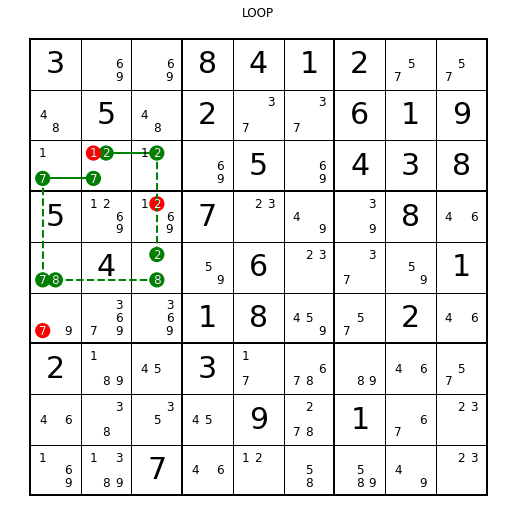

In [51]:
db10.show_query(q)

In [380]:
t.show_techniques('loop')

In [374]:
t.init()